# Big Data FC

The goal of the **Big Data FC** project is to **predict** how many **points** a **football team** belonging to the main European football leagues will end the season with, according to the **characteristics of its players**.

To reach the goal, data relative to the **football players** will first be loaded, in order to then compose the **football teams**.
After that, a second dataset will be used to gather seasonal **rankings**, for every football team.

The project as a whole is composed of:

* This **notebook**, containing all steps of:
  * Data loading.
  * Data cleaning and pre-processing
  * Data visualization.
  * Data analysis.
  * Learning and evaluation.
* A custom [**scraper**](https://github.com/Big-Data-FC/scraper), to gather further players data.
* A set of **REST APIs** to query the loaded data and the prediction model.
* The collection of [scraped datasets](https://github.com/Big-Data-FC/datasets).

During the project, multiple approaches and techniques were explored, all described in this notebook.

_By [Daniele Solombrino](https://github.com/dansolombrino) and [Davide Quaranta](https://github.com/fortym2)._

# Initial imports

Before getting started, a series of components that are used across the entire project are imported.

In [1]:
#  PySpark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import gc

import builtins
import operator
import json

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib widget

import pandas as pd
import numpy as np


# import itertools


# import copy

# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import StandardScaler
# from pyspark.ml.feature import PCA


# from tqdm import tqdm

# from pyspark.ml.clustering import KMeans
# from pyspark.ml.feature import Normalizer

# RANDOM_SEED = None

# from pyspark.ml.evaluation import ClusteringEvaluator

# from pyspark.ml.linalg import Vectors

# from functools import reduce

# from pyspark.ml.regression import LinearRegression

# from pyspark_dist_explore import hist

# from pyspark.ml.regression import RandomForestRegressor

# from pyspark.ml.regression import DecisionTreeRegressor

# from pyspark.ml import Pipeline

# from pyspark.ml.tuning import ParamGridBuilder

# from pyspark.ml.tuning import CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator

# from pyspark.ml.regression import GBTRegressor

# from pyspark.ml.classification import MultilayerPerceptronClassifier

# from pyspark.ml.classification import LogisticRegression

# from pyspark.ml.classification import LinearSVC, OneVsRest
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.classification import RandomForestClassifier

# from operator import itemgetter

# from pyspark.ml.feature import MinMaxScaler

# from pyspark.ml.linalg import Vectors, VectorUDT

# from pyspark.ml.stat import Summarizer

# from sklearn.decomposition import KernelPCA

# from pyspark.ml.feature import UnivariateFeatureSelector
# from pyspark.ml.linalg import DenseVector
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt 
# import seaborn as sns
# import re

# import sklearn
# from sklearn.model_selection import train_test_split
# # from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import scale
# from sklearn.feature_selection import RFE
# # from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline

# from sklearn.model_selection import cross_val_score

# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# # from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# # from sklearn.ensemble import RandomForestRegressor

# from sklearn.preprocessing import FunctionTransformer


# import warnings # supress warnings
# warnings.filterwarnings('ignore')

# Spark

The following cell initializes the Spark context, with a given configuration.

In [2]:
conf = (
    SparkConf()
    .set("spark.ui.port", "4050")
    .set("spark.executor.memory", "4G")
    .set("spark.driver.memory", "20G")
    .set("spark.driver.maxResultSize", "10G")
)
# .set("spark.master", "spark://192.168.1.189:4050")


# create the context
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")


spark = SparkSession.builder.getOrCreate()

22/06/18 10:58:20 WARN Utils: Your hostname, macchinario resolves to a loopback address: 127.0.1.1; using 192.168.1.12 instead (on interface enp0s31f6)
22/06/18 10:58:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/18 10:58:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading football players

First step is to load football players data, which comes from to two different sources:

* For seasons between 2015 and 2020 (called "modern"): [FIFA 15-21 complete dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset)

* For season between 2007 and 2014 (called "legacy"): scraped data from [sofifa.com](https://sofifa.com), a website specialized in storing data taken from EA Sports FIFA games.

As introduced before, scraped datasets are committed in a [GitHub repository](https://github.com/Big-Data-FC/datasets).

From now on, the terms "modern" and "legacy" will be used to refer to the two kinds of datasets.

Initially, modern and legacy data will be splitted in two different dataframes, since there are some differences in the structure of their data, among these different years.

In [3]:
modern_df = spark.read.csv(
    "data/players_*.csv", sep=",", inferSchema=True, header=True, multiLine=True
)

legacy_df = spark.read.csv(
    "data/scraped_players_*.csv", sep=",", inferSchema=True, header=True, 
    multiLine=True
)

# Pre-processing football players

In order to focus the project on the major European leagues, it is useful to define a list of leagues to filter, and also to define a list of season to easily discriminate between modern an legacy data.

In [4]:
# These are the European Leagues supported by Big-Data-FC
leagues = [
    "Italian Serie A",
    # "Spain Primera Division",
    # "German 1. Bundesliga",
    # "French Ligue 1",
    # "English Premier League",
    # "Holland Eredivisie",
]

# These are the seasons supported by Big-Data-FC
# seasons_modern = ["20", "19", "18", "17", "16", "15", "14"] 
seasons_modern = ["20"] 
# seasons_legacy = ["13", "12", "11", "10", "09", "08", "07"]
seasons_legacy = ["13"]
seasons = seasons_legacy + seasons_modern

The next definition is about **macro roles**, which is a custom-defined abstration to aggregate affine football roles.

For example, all the midfield roles such as "central midfielder", "advanced midfielder", "left|right wing" can be **grouped together** in the same macro role "midfielder".

Macro roles will be used later on, in a subsequent learning phase. For this reason, much more about them will be touched in future points.

The following cell defines the actual aggregation from FIFA roles abbreviations into macro roles.

In [5]:
macro_roles = ["0.0", "1.0", "2.0", "3.0"]

roles_to_macro_roles_dict = {
    "GK": "0",
    "LB": "1",
    "RB": "1",
    "RWB": "1",
    "LWB": "1",
    "CB": "1",
    "CDM": "2",
    "CM": "2",
    "RM": "2",
    "LM": "2",
    "CAM": "2",
    "RW": "3",
    "LW": "3",
    "ST": "3",
    "LF": "3",
    "RF": "3",
    "CF": "3",
}

NUM_MACRO_ROLES = 4

roles_to_macro_role_UDF = udf(
    lambda roles: float(
        roles_to_macro_roles_dict[roles.split(",")[0]]
    ), 
    StringType()
)

Since the columns associeted to players also contain graphical or data that is generally not informative for the project's purpose (such as shirt number, celebration moves, etc), a list of meaningful columns has been defined, on which the actual working dataframes will be based on.

In [6]:
columns = [
    "short_name",
    "club_name",
    "league_name",
    "season",
    "player_positions",
    "macro_role",
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

Datasets do **not** explicitly include the **year** (season) to which the record refers to.

Rather, this information is implicitly stored in a URL (also for the non-scraped ones, which still originate from the same source), which has its own field.
For this reason, a function to extract such information from aforementioned field is needed.

As an example, a if the URL is `/player/41236/zlatan-ibrahimovic/130034/`, the corresponding season is `13` (from `/13xxxx/`).

In [7]:
def get_season(url):
    url_split = url.split("/")

    # FIFA years must be scaled by a negative factor of one (i.e. 2021 has to be 2020, etc.)
    # This is needed to ensure compatibility with the seasonal score dataset
    return str(
        (int(url_split[-2 if url_split[-1] == "" else -1][0:2]) - 1)
    ).zfill(2)

get_season_UDF = udf(lambda url: get_season(url), StringType())

The format of the **monetary value** of players is different among the modern and legacy dataset.

Specifically, the legacy one abbreviates the values into the form `€10M` to represent `€10000000`.

The following function is used to convert it into the extended one.

In [8]:
@udf
def expand_value_UDF(value):
    value = value.replace("€", "")
    if value[-1] not in ("K", "M"):
        # no abbreviation at the end
        return value

    # extract the number and the unit
    num = value[:-1]
    unit = value[-1]

    # decide based on the unit
    if unit == "M":
        return float(num) * 1000000
    if unit == "K":
        return float(num) * 1000

    return "ERROR"

Now to the actual pre-process.

Some actions are needed by legacy and modern both, whilst other are exclusive to either one.

In [9]:
# Extracting season from the player URL, as per previous cell
pre_processed_modern_df = modern_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)
pre_processed_legacy_df = legacy_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)

# Taking only the players playing for teams in supported Leagues, 
# in the supported seasons
pre_processed_modern_df = pre_processed_modern_df.where(
    (pre_processed_modern_df.league_name.isin(leagues))
    &
    (pre_processed_modern_df.season.isin(seasons_modern))
)
pre_processed_legacy_df = pre_processed_legacy_df.where(
    (pre_processed_legacy_df.league_name.isin(leagues))
    &
    (pre_processed_legacy_df.season.isin(seasons_legacy))
)

# Dropping duplicate players
pre_processed_modern_df = pre_processed_modern_df.dropDuplicates(["player_url"])
pre_processed_legacy_df = pre_processed_legacy_df.dropDuplicates(["player_url"])

# Selected columns have been checked for absence of null/missing data.
# Nevertheless, to ensure compatibility and reusability with other datasets, 
# a null-filling sweep is done
pre_processed_modern_df = pre_processed_modern_df.na.fill(0)
pre_processed_legacy_df = pre_processed_legacy_df.na.fill(0)

# Getting the macro role of the player, according to its field position
pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)

# Renaming the "value_eur" field to "value" to have compatiblity with legacy
pre_processed_modern_df = pre_processed_modern_df.withColumnRenamed(
    "value_eur", "value"
)

# Convert the monetary value to have compatibility with modern
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "value", expand_value_UDF(col("value"))
)

# Renaming some legacy columns, so as they have the same name as in the modern
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pas", "passing"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "dri", "dribbling"
)
pre_processed_legacy_df = pre_processed_legacy_df.drop(col("defending"))
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "def", "defending"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "phy", "physic"
)

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "sho", "shooting"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pac", "pace"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "bov", "overall"
)

# Keeping only the needed columns.
pre_processed_modern_df = pre_processed_modern_df.select(columns)
pre_processed_legacy_df = pre_processed_legacy_df.select(columns)

Checking whether some monetary values have not been successfully converted.

In [10]:
if pre_processed_legacy_df.select("value").where(col("value") == "ERROR").count() > 0:
    print("WARN: some abbreviated monetary values were not correctly expanded.")

After pre-processing, both dataframes have the same set of columns, so they can be concatenated together.

In [11]:
pre_processed_df = pre_processed_modern_df.unionByName(
    pre_processed_legacy_df
)

## Cleaning up memory

In [12]:
del legacy_df
del modern_df
del pre_processed_legacy_df
del pre_processed_modern_df
gc.collect()

593

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [13]:
pre_processed_df.select(*columns[0:10]).show()

+---------------+----------+---------------+------+----------------+----------+-------+--------+----+--------+
|     short_name| club_name|    league_name|season|player_positions|macro_role|overall|   value|pace|shooting|
+---------------+----------+---------------+------+----------------+----------+-------+--------+----+--------+
|       C. Terzi|    Spezia|Italian Serie A|    20|              CB|       1.0|     68|  180000|  47|      41|
|      G. Pegolo|  Sassuolo|Italian Serie A|    20|              GK|       0.0|     70|  180000|   0|       0|
|      G. Buffon|  Juventus|Italian Serie A|    20|              GK|       0.0|     82| 2200000|   0|       0|
|        P. Gori| Benevento|Italian Serie A|    20|              GK|       0.0|     62|   30000|   0|       0|
|      G. Pandev|     Genoa|Italian Serie A|    20|          ST, RW|       3.0|     72| 1100000|  44|      74|
|    Bruno Alves|     Parma|Italian Serie A|    20|              CB|       1.0|     72|  625000|  35|      67|
|

The complete list of columns is (again for graphical reasons) printed here in an horizontal format, where each item is a tuple of the form `(field_name, type)`.

In [14]:
print(pre_processed_df.dtypes)

[('short_name', 'string'), ('club_name', 'string'), ('league_name', 'string'), ('season', 'string'), ('player_positions', 'string'), ('macro_role', 'string'), ('overall', 'int'), ('value', 'string'), ('pace', 'int'), ('shooting', 'int'), ('passing', 'int'), ('dribbling', 'int'), ('defending', 'int'), ('physic', 'int'), ('attacking_crossing', 'int'), ('attacking_finishing', 'int'), ('attacking_heading_accuracy', 'int'), ('attacking_short_passing', 'int'), ('skill_dribbling', 'int'), ('skill_fk_accuracy', 'int'), ('skill_long_passing', 'int'), ('skill_ball_control', 'int'), ('movement_acceleration', 'int'), ('movement_sprint_speed', 'int'), ('movement_reactions', 'int'), ('power_shot_power', 'int'), ('power_stamina', 'int'), ('power_strength', 'int'), ('power_long_shots', 'int'), ('mentality_aggression', 'int'), ('mentality_penalties', 'int'), ('defending_standing_tackle', 'int')]


# Building football teams

In [15]:
football_teams_df = pre_processed_df

After having pre-processed the football players, it's time to build the football teams.

For the sake of the learning stage of the project, **teams are differentiated across different seasons**; for example, Real Madrid of 2020 is **different** than Real Madrid of 2018.

A football team is then modeled as **the set of the average of the features of all of its football players**.

In [16]:
# Columns that are considered as features
PLAYER_FEATURES = [
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

# Apposing the avg pre-fix to features
PLAYER_FEATURES_AVG = [
    "avg(" + player_feature + ")" for player_feature in PLAYER_FEATURES
]

# Target variable of the learning stage
TARGET_VARIABLE = "points"

Composing the football team, as introduced before.

In [17]:
football_teams_df = football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES
).groupBy(
    ["season", "club_name"]
).agg(
    { player_feature: "avg" for player_feature in PLAYER_FEATURES }
)

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [18]:
football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES_AVG[0:5]
).show()

+------+-------------+-----------------+--------------------+------------------+------------------+------------------+
|season|    club_name|     avg(overall)|          avg(value)|         avg(pace)|     avg(shooting)|      avg(passing)|
+------+-------------+-----------------+--------------------+------------------+------------------+------------------+
|    20|      Udinese|70.15151515151516|  3373636.3636363638|55.484848484848484| 47.54545454545455| 51.60606060606061|
|    20|     Cagliari|           69.625|          3688281.25|           58.4375|          51.90625|          55.46875|
|    20|     Juventus|77.48387096774194| 1.691774193548387E7|  64.6774193548387|55.064516129032256| 62.32258064516129|
|    20|        Genoa|70.45454545454545|   3045151.515151515| 58.03030303030303|51.333333333333336| 56.90909090909091|
|    20|        Lazio|75.51515151515152|1.0902272727272727E7| 65.15151515151516|              55.0| 60.09090909090909|
|    20|     Sassuolo| 70.6969696969697|   42980

The complete list of columns with their type is (in a compact horizontal form):

In [19]:
print(football_teams_df.dtypes)

[('season', 'string'), ('club_name', 'string'), ('avg(attacking_short_passing)', 'double'), ('avg(shooting)', 'double'), ('avg(power_stamina)', 'double'), ('avg(skill_long_passing)', 'double'), ('avg(power_strength)', 'double'), ('avg(defending_standing_tackle)', 'double'), ('avg(skill_fk_accuracy)', 'double'), ('avg(skill_dribbling)', 'double'), ('avg(dribbling)', 'double'), ('avg(pace)', 'double'), ('avg(mentality_aggression)', 'double'), ('avg(movement_reactions)', 'double'), ('avg(movement_sprint_speed)', 'double'), ('avg(passing)', 'double'), ('avg(movement_acceleration)', 'double'), ('avg(attacking_heading_accuracy)', 'double'), ('avg(attacking_finishing)', 'double'), ('avg(defending)', 'double'), ('avg(attacking_crossing)', 'double'), ('avg(power_long_shots)', 'double'), ('avg(mentality_penalties)', 'double'), ('avg(overall)', 'double'), ('avg(power_shot_power)', 'double'), ('avg(value)', 'double'), ('avg(physic)', 'double'), ('avg(skill_ball_control)', 'double')]


# Loading football teams seasonal scores

After having dealt with the football players and composed them into football clubs, it's time to get **"target" data** for the learning stage: the final ranking, for every team of every year.

First step is to load the data from disk, which has been taken from the [European Football Dataset](https://www.kaggle.com/datasets/josephvm/european-club-football-dataset)

In [20]:
seasonal_scores_df = (
    spark.read.csv(
        "data/all_tables_fixed_renamed_leagues.csv",
        sep=",",
        inferSchema=True,
        header=True,
        multiLine=True,
    )
    .withColumnRenamed("Year", "season")
    .withColumnRenamed("Team", "club_name")
    .withColumnRenamed("P", "points")
    .withColumnRenamed("Place", "place")
    .withColumnRenamed("League", "league")
)

# Pre-processing football teams seasonal scores

Out of all the available columns, only the ones in `seasonal_scores_columns` will be taken into consideration.

In [21]:
seasonal_scores_columns = [
    "season", "league", "club_name", "points", "place"
]

The seasonal scores dataset uses **abbreviated version of football team names** (for example: `BAR` for Barcelona, `LEI` for Leicester, etc.), which would cause **incompatibility** with modern and legacy FIFA datasets, which instead uses complete names.

Furthermore, the abbreviations are **not standard**, so there are **conflicts** such as, among others:

* `BAR` both for Barcelona and Bari (different leagues).
* `HUE` both for Huelva and Huesca (same league).

For this reason, a **custom** hand-made **mapping** procedure has been developed in order to resolve such conflicts.

Another source of incompatibility originated from **inconsistencies** within FIFA datasets, from year to year; for example, some teams had slight variations in their names (e.g. Torino and Torino FC).

All said inconsistencies have been **manually solved** and disambiguated at the dataset-level.

Furthermore, the final **mapping** between abbreviations and FIFA names resulted into a **custom-made dataset** (also available in the linked dataset GitHub repo), which is the following form:

|abbr|league|club_name|fifa_club_name|
|---|---|---|---|
|AAC|German Bundesliga|Aachen|Alemannia Aachen|
|ADO|Dutch Eredivisie|Ado Den Haag|ADO Den Haag|
|AJA|Dutch Eredivisie|Ajax|Ajax|
|AJC|French Ligue 1|Ajaccio|AC Ajaccio|
|ALB|Spanish La Liga|Albacete|Albacete BP|
|...|...|...|...|

Aforementioned mapping is then converted to **JSON** with an utility script in the same repository, and loaded here in a dataframe.

In [22]:
f = open("data/clubs_map.json")
club_name_abbr_to_ext = json.load(f)
f.close()

ABBREVIATED_CLUB_NAME_NOT_FOUD = "ABBREVIATED_CLUB_NAME_NOT_FOUD"
GENERAL_EXCEPTION = "GENERAL_EXCEPTION"

def extend_club_name(club_name_abbr):
    try:
        return club_name_abbr_to_ext[club_name_abbr]
    except KeyError as e:
        return ABBREVIATED_CLUB_NAME_NOT_FOUD
    except Exception as e:
        return GENERAL_EXCEPTION

extend_club_name_UDF = udf(
    lambda club_name_abbr: extend_club_name(str(club_name_abbr)),
    StringType(),
)

In the rankings dataset the seasons are expressed as `YYYY`, whilst FIFA uses the `YY` encoding.

For this reason, to guarantee compatibility, season values in the rankings dataset is abbreviated.

In [23]:
abbreviate_season_UDF = udf(
    lambda season: str(season)[-2:],
    StringType(),
)

The following is the actual **data pre-processing**.

In [24]:
pre_processed_seasonal_scores_df = seasonal_scores_df

# Abbreviating season, as per previous cell
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "season", abbreviate_season_UDF(col("season"))
)

# Keeping only supported leagues in supported seasons
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.where(
    (pre_processed_seasonal_scores_df.season.isin(seasons))
    & 
    (pre_processed_seasonal_scores_df.league.isin(leagues))
)

# Selecting only the desired columns
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_columns
)

# Although data has been checked for duplicates and missing value, to ensure 
# operabiloty with other datasets, the pre-processing steps are still performed
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.dropDuplicates(
    seasonal_scores_columns
)
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.na.fill(0)

# Extending club names, as per previous cell
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "club_name", extend_club_name_UDF(col("club_name"))
)
# Checking whether club name expansions went all good or not
if pre_processed_seasonal_scores_df.filter(
    col("club_name") == ABBREVIATED_CLUB_NAME_NOT_FOUD
).count() > 0:
    print("WARN: some clubs have NOT been found")
    print("Please check your data")

# Casting points to float, as required by learning procedures
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "points", pre_processed_seasonal_scores_df.points.cast(DoubleType())
)

This is the end result of this section:

In [25]:
pre_processed_seasonal_scores_df.show()

+------+---------------+-------------+------+-----+
|season|         league|    club_name|points|place|
+------+---------------+-------------+------+-----+
|    20|Italian Serie A|    Sampdoria|  52.0|    9|
|    20|Italian Serie A|Hellas Verona|  45.0|   10|
|    13|Italian Serie A|      Udinese|  44.0|   13|
|    13|Italian Serie A|Hellas Verona|  54.0|   10|
|    13|Italian Serie A|       Torino|  57.0|    7|
|    13|Italian Serie A|    Sampdoria|  45.0|   12|
|    20|Italian Serie A|      Bologna|  41.0|   12|
|    13|Italian Serie A|   Fiorentina|  65.0|    4|
|    20|Italian Serie A|        Genoa|  42.0|   11|
|    20|Italian Serie A|    Benevento|  33.0|   18|
|    13|Italian Serie A|         Roma|  85.0|    2|
|    13|Italian Serie A|        Lazio|  56.0|    9|
|    20|Italian Serie A|      Udinese|  40.0|   14|
|    20|Italian Serie A|        Inter|  91.0|    1|
|    13|Italian Serie A|      Bologna|  29.0|   19|
|    20|Italian Serie A|         Roma|  62.0|    7|
|    13|Ital

# Joining football teams features with their seasonal scores

The two dataframes (players and seasonal scores) need to be merged together to form a single dataframe.
This can easily be done by joining on the key (`season`, `club_name`).

In [26]:
df = football_teams_df.join(
    pre_processed_seasonal_scores_df,
    on = ["season", "club_name"],
)

In order to check whether some clubs were left out by the aforementioned join operation, two differences are computed:

* Seasonal scores dataframe - joined dataframe.
* Football teams dataframe - joined dataframe.

In [27]:
diff = pre_processed_seasonal_scores_df.select("club_name").subtract(df.select("club_name")).distinct()

if diff.count() > 0:
    print("WARN: Some football teams have been left out the join (pre_processed_seasonal_scores_df)")
    diff.show()

diff = football_teams_df.select("club_name").subtract(df.select("club_name")).distinct()
if diff.count() > 0:
    print("WARN: Some football teams have been left out the join (football_teams_df)")
    diff.show()

del diff

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [28]:
df.select(
    "season", "league", "club_name", "avg(overall)", "avg(pace)", "points", "place"
).show()

+------+---------------+-------------+-----------------+------------------+------+-----+
|season|         league|    club_name|     avg(overall)|         avg(pace)|points|place|
+------+---------------+-------------+-----------------+------------------+------+-----+
|    20|Italian Serie A|      Udinese|70.15151515151516|55.484848484848484|  40.0|   14|
|    20|Italian Serie A|     Cagliari|           69.625|           58.4375|  37.0|   16|
|    20|Italian Serie A|     Juventus|77.48387096774194|  64.6774193548387|  78.0|    4|
|    20|Italian Serie A|        Genoa|70.45454545454545| 58.03030303030303|  42.0|   11|
|    20|Italian Serie A|        Lazio|75.51515151515152| 65.15151515151516|  68.0|    6|
|    20|Italian Serie A|     Sassuolo| 70.6969696969697|60.666666666666664|  62.0|    8|
|    20|Italian Serie A|       Torino|71.06060606060606| 56.54545454545455|  37.0|   17|
|    20|Italian Serie A|       Spezia|65.48387096774194|52.806451612903224|  39.0|   15|
|    20|Italian Serie

The full list of columns with their type is (in a compact horizontal form):

In [29]:
print(df.dtypes)

[('season', 'string'), ('club_name', 'string'), ('avg(attacking_short_passing)', 'double'), ('avg(shooting)', 'double'), ('avg(power_stamina)', 'double'), ('avg(skill_long_passing)', 'double'), ('avg(power_strength)', 'double'), ('avg(defending_standing_tackle)', 'double'), ('avg(skill_fk_accuracy)', 'double'), ('avg(skill_dribbling)', 'double'), ('avg(dribbling)', 'double'), ('avg(pace)', 'double'), ('avg(mentality_aggression)', 'double'), ('avg(movement_reactions)', 'double'), ('avg(movement_sprint_speed)', 'double'), ('avg(passing)', 'double'), ('avg(movement_acceleration)', 'double'), ('avg(attacking_heading_accuracy)', 'double'), ('avg(attacking_finishing)', 'double'), ('avg(defending)', 'double'), ('avg(attacking_crossing)', 'double'), ('avg(power_long_shots)', 'double'), ('avg(mentality_penalties)', 'double'), ('avg(overall)', 'double'), ('avg(power_shot_power)', 'double'), ('avg(value)', 'double'), ('avg(physic)', 'double'), ('avg(skill_ball_control)', 'double'), ('league', 'st

## Cleaning up memory

In [30]:
del seasonal_scores_df
del pre_processed_seasonal_scores_df
del football_teams_df
gc.collect()

398

# Visualizations

A good practice whenever a data-driven task is being taclked is to first visualize the data.

In fact, even just by simply looking at data we may find some useful information which may have a direct impact on the subsequent learning phase.

## Points distribution

Kicking the visualization stage off with data distirbutions for the end-of-season points, across all supported seasons, for all supported leagues.

Data distribution is very important to monitor: exposing a model too many or too few time to a value may be source of bias, which we want to avoid.

Text(0.5, 1.0, 'Points distribution across all leagues')

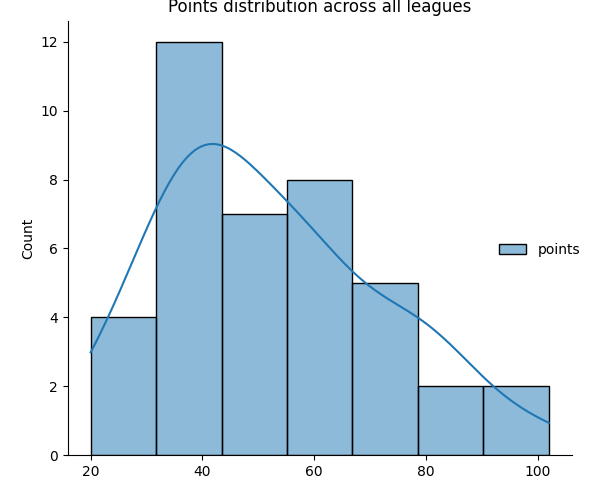

In [31]:
p = sns.displot(df.select("points").toPandas(), kde=True)
p.fig.tight_layout(pad=1.5)
plt.title("Points distribution across all leagues")

Some observations can be done:

1. Data tends to approximatively follow a Gaussian/Normal distribution
2. Said distribution appears to be slighlty skewed towards left

These observations perfectly coincide with domain knowledge.
1. In every league, there are just a few very strong teams (Champions League qualifiers), a limited number of very bad teams (fighting for relegation) and then a multitude of middle-table teams
2. Some leagues do not have much talent in the middle part of the table, resulting in a general "equilibrium" between such team.
As a result, scores of such teams not be high, but rather close to the mean value. 

The following density plot instead focuses on each league, showing again the points distribution.

Text(0.5, 1.0, 'Points distribution per league')

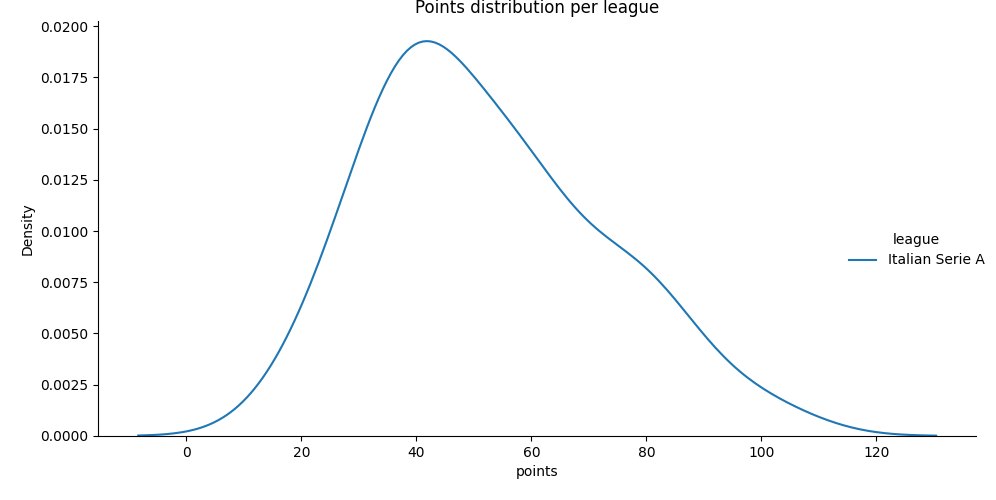

In [32]:
p = sns.displot(df.toPandas(), x="points", hue="league", kind="kde", aspect=1.7, palette="tab10")
p.fig.tight_layout(pad=1.5)
plt.title("Points distribution per league")

Some observations can be made:

* The **French** and **Spanish** leagues are the less skewed among all leagues, possibly meaning that they are characterized by a majority of "average" teams.
* The **Italian** and **English** leagues are very similar on low and middle points, but start to behave slightly different on the middle-high and high parts of the table.
* The **Dutch** league is the most left-skewed, possibly hinting at the lower quality of the league, as suggested by the domain knowledge.
* The **Spanish** league has a boost on high points, hinting at a consistent dominancy of one or more teams.

## Overall player quality distribution

Similar visualizations can be done to analyze the overall player quality.

The following plot shows the distribution of the player quality (`avg(overall)`) across all leagues.

Text(0.5, 1.0, 'Player quality across all leagues')

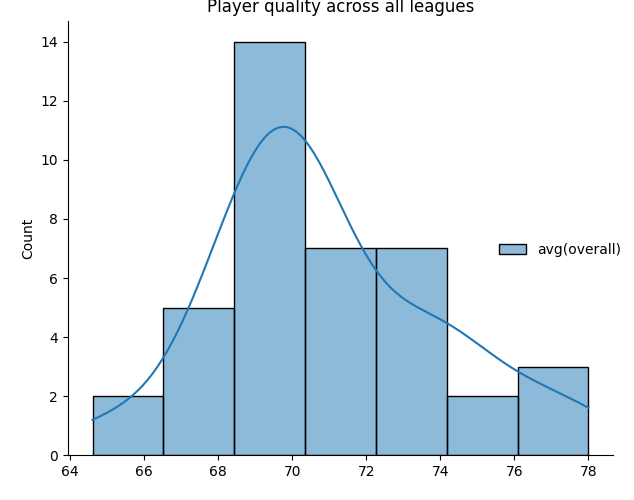

In [33]:
p = sns.displot(df.select("avg(overall)").toPandas(), kde=True)
p.fig.tight_layout(pad=1.5)
plt.title("Player quality across all leagues")

Similarily to what observed for the points, the plot shows that:

* A vast majority of the players are of average quality.
* A minority of the players are below-average.
* A minority of the players are above-average.

The following plot focuses on the single leagues.

Text(0.5, 1.0, 'Player quality per league')

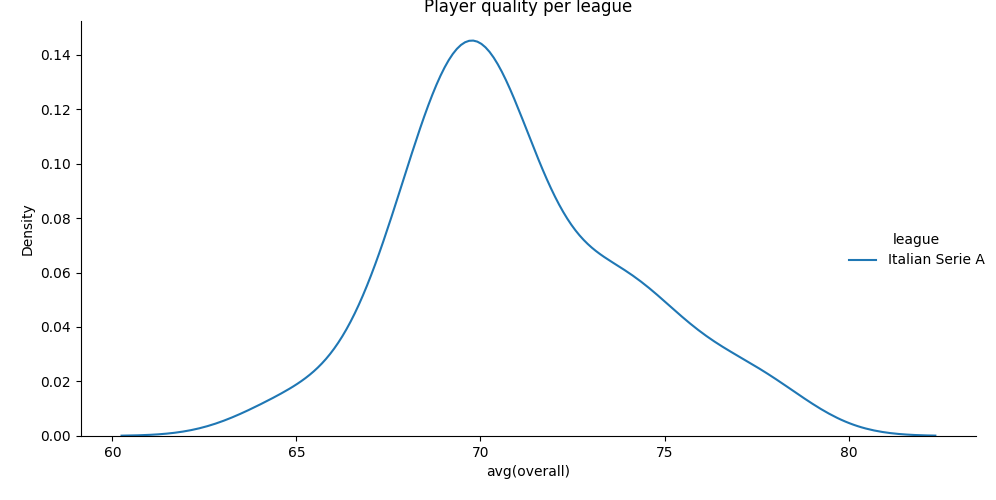

In [34]:
p = sns.displot(df.toPandas(), x="avg(overall)", hue="league", kind="kde", aspect=1.7, palette="tab10")
p.fig.tight_layout(pad=1.5)
plt.title("Player quality per league")

From the plot it is possible to observe that:

* The Dutch league hosts the majority of below-average players.
* The French league follows the Dutch one in below-average players.
* The German league has the highest amount of average players.
* The German, Engligh, Italian and Spanish leagues have a peak of average players.
* The same leagues have a considerable amount of above-average players.
* The Spanish leagues dominates on the above-average players.

# Attempt 1: "naive" player features

The following section represents the first attempt at building a model able to predict the points of a team, considering the features of its players.

This attempt has been renamed as "naive", meaning that it simply consist of an analysis based on **all the features** that are related to a **player's technical abilities**.

In [35]:
# remove columns that do not inherently represent players abilities
ALL_FEATURES = PLAYER_FEATURES_AVG
ALL_FEATURES.remove("avg(overall)")
ALL_FEATURES.remove("avg(value)")


The learning procedures require that the considered features are assembled in a vector.

The following cell performs this operation by adding a new "assembled" column to the main dataframe.

In [36]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=ALL_FEATURES, outputCol="all_vec"
)

df = assembler.transform(df)

It is convenient to define a some custom utility functions to plot multiple figures, that will be called multiple times along the course of the project.

The following cells contain the definition of said functions.

In [37]:
def plot_feature_target_relation(
    data, x, y, n_rows = 12, n_cols = 2, figsize = (15, 30), color = "#000000"
):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for x_ind, x_value in enumerate(x):
        ax = sns.regplot(
            data=data,
            x=x_value,
            y=y,
            color = color,
            ax=axes[x_ind // n_cols, x_ind % n_cols],
        )


    fig.tight_layout()

In [38]:
def plot_feature_distribution(
    data,
    features,
    figsize=(4,4), 
    color="#000000",
    n_cols=2
):

    n_rows = int(len(features) / n_cols) if len(features) >= n_cols else n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for feature_ind, feature in enumerate(features):
        _ = sns.histplot(
            data[feature],
            kde=True,
            color=color,
            facecolor=color,
            ax=axes[feature_ind // n_cols, feature_ind % n_cols] if n_rows > 1 else axes[feature_ind],
        )

    fig.tight_layout(pad=1.5)

In [39]:
def plot_correlation_matrix(
    data, features, title="Pearson Correlation Matrix", figsize=(16,12)
):

    mask = np.zeros_like(data[features].corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):  # Temporarily set the background to white
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=24)

        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        _ = sns.heatmap(
            data[features].corr(),
            linewidths=0.25,
            vmax=0.7,
            square=True,
            ax=ax,
            cmap=cmap,
            linecolor="w",
            annot=True,
            annot_kws={"size": 8},
            mask=mask,
            cbar_kws={"shrink": 0.9},
        )

Before learning, it is good practice to first gather in-depth information on the structure of the data, as well as obtaining useful visualizations.

In the following sections, multiple approaches at data visualization will be given.

## Raw data

In this section a first analysis is performed on _raw_ data, meaning that no normalization or standardization is performed.

In [40]:
# color to be used in the plots for raw data
COLOR_RAW = "#332FD0"

In [41]:
# use Pandas for easy plotting with Seaborn
pdf = df.toPandas()

### Feature-target correlation

The **feature-target correlation** shows the correlation between each feature and the target variable (point).

The idea is to immediately visualize whether there are specific features that are particularly correlated with the target variable.

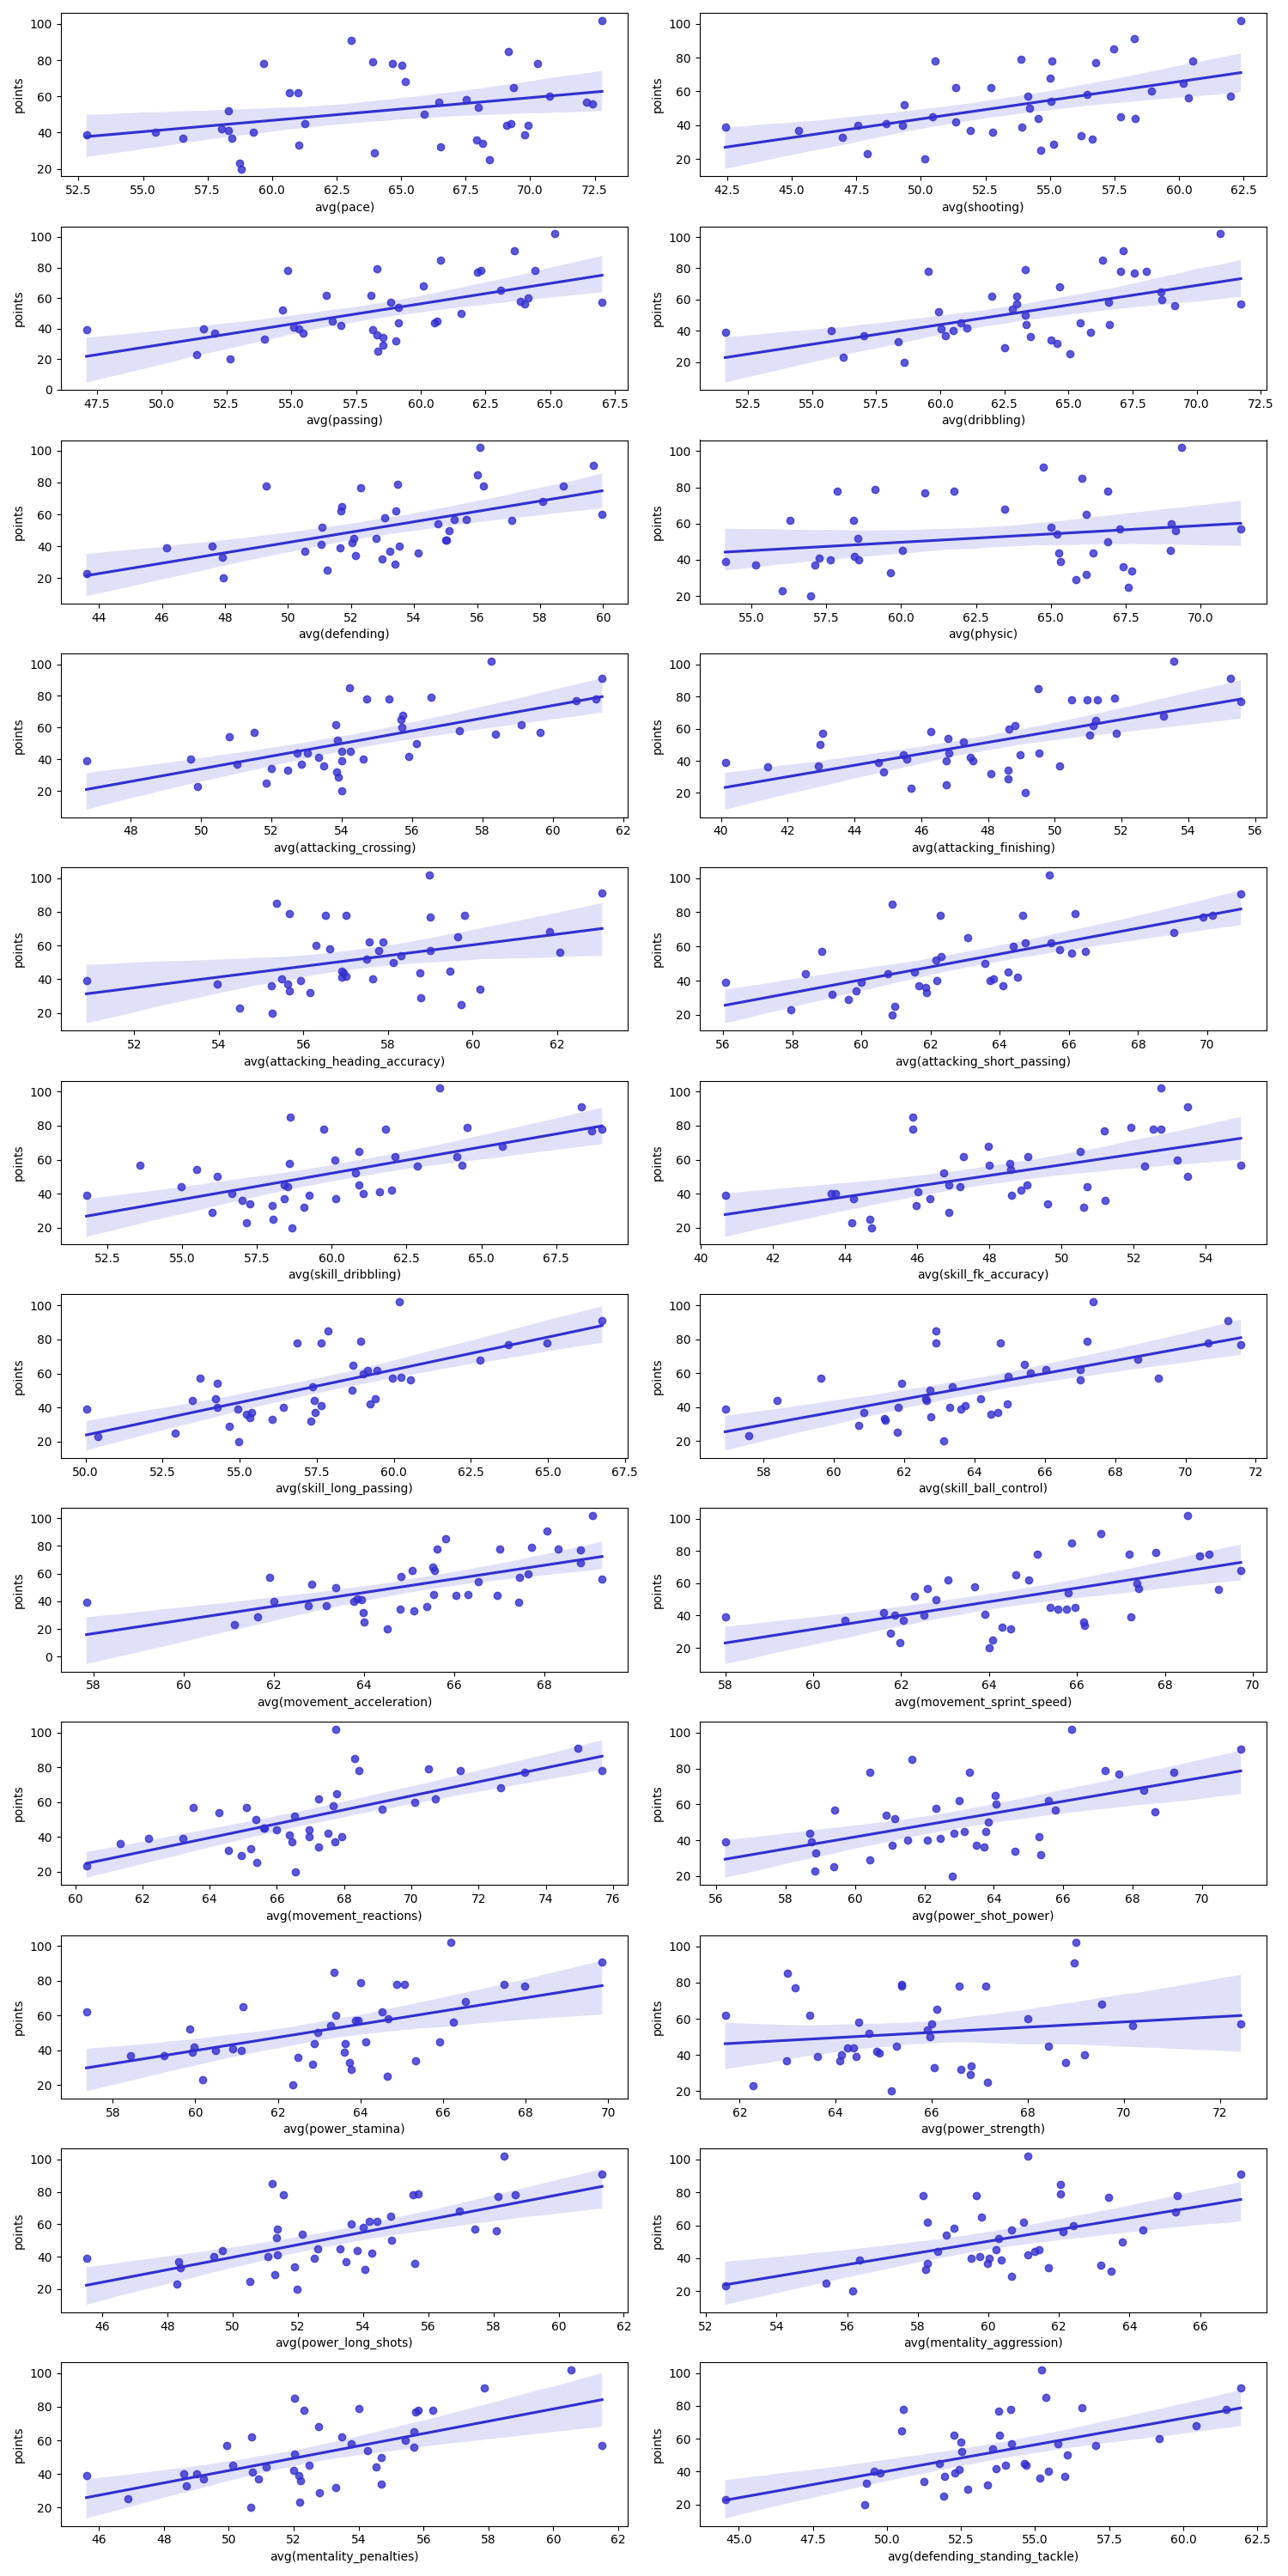

In [42]:
plot_feature_target_relation(
    pdf, ALL_FEATURES, TARGET_VARIABLE, color=COLOR_RAW
)

Since there are too many datapoints, it is very hard to look at the plots. Let's see how visualizations change when focusing on some leagues or years, thus restricting the data scope.

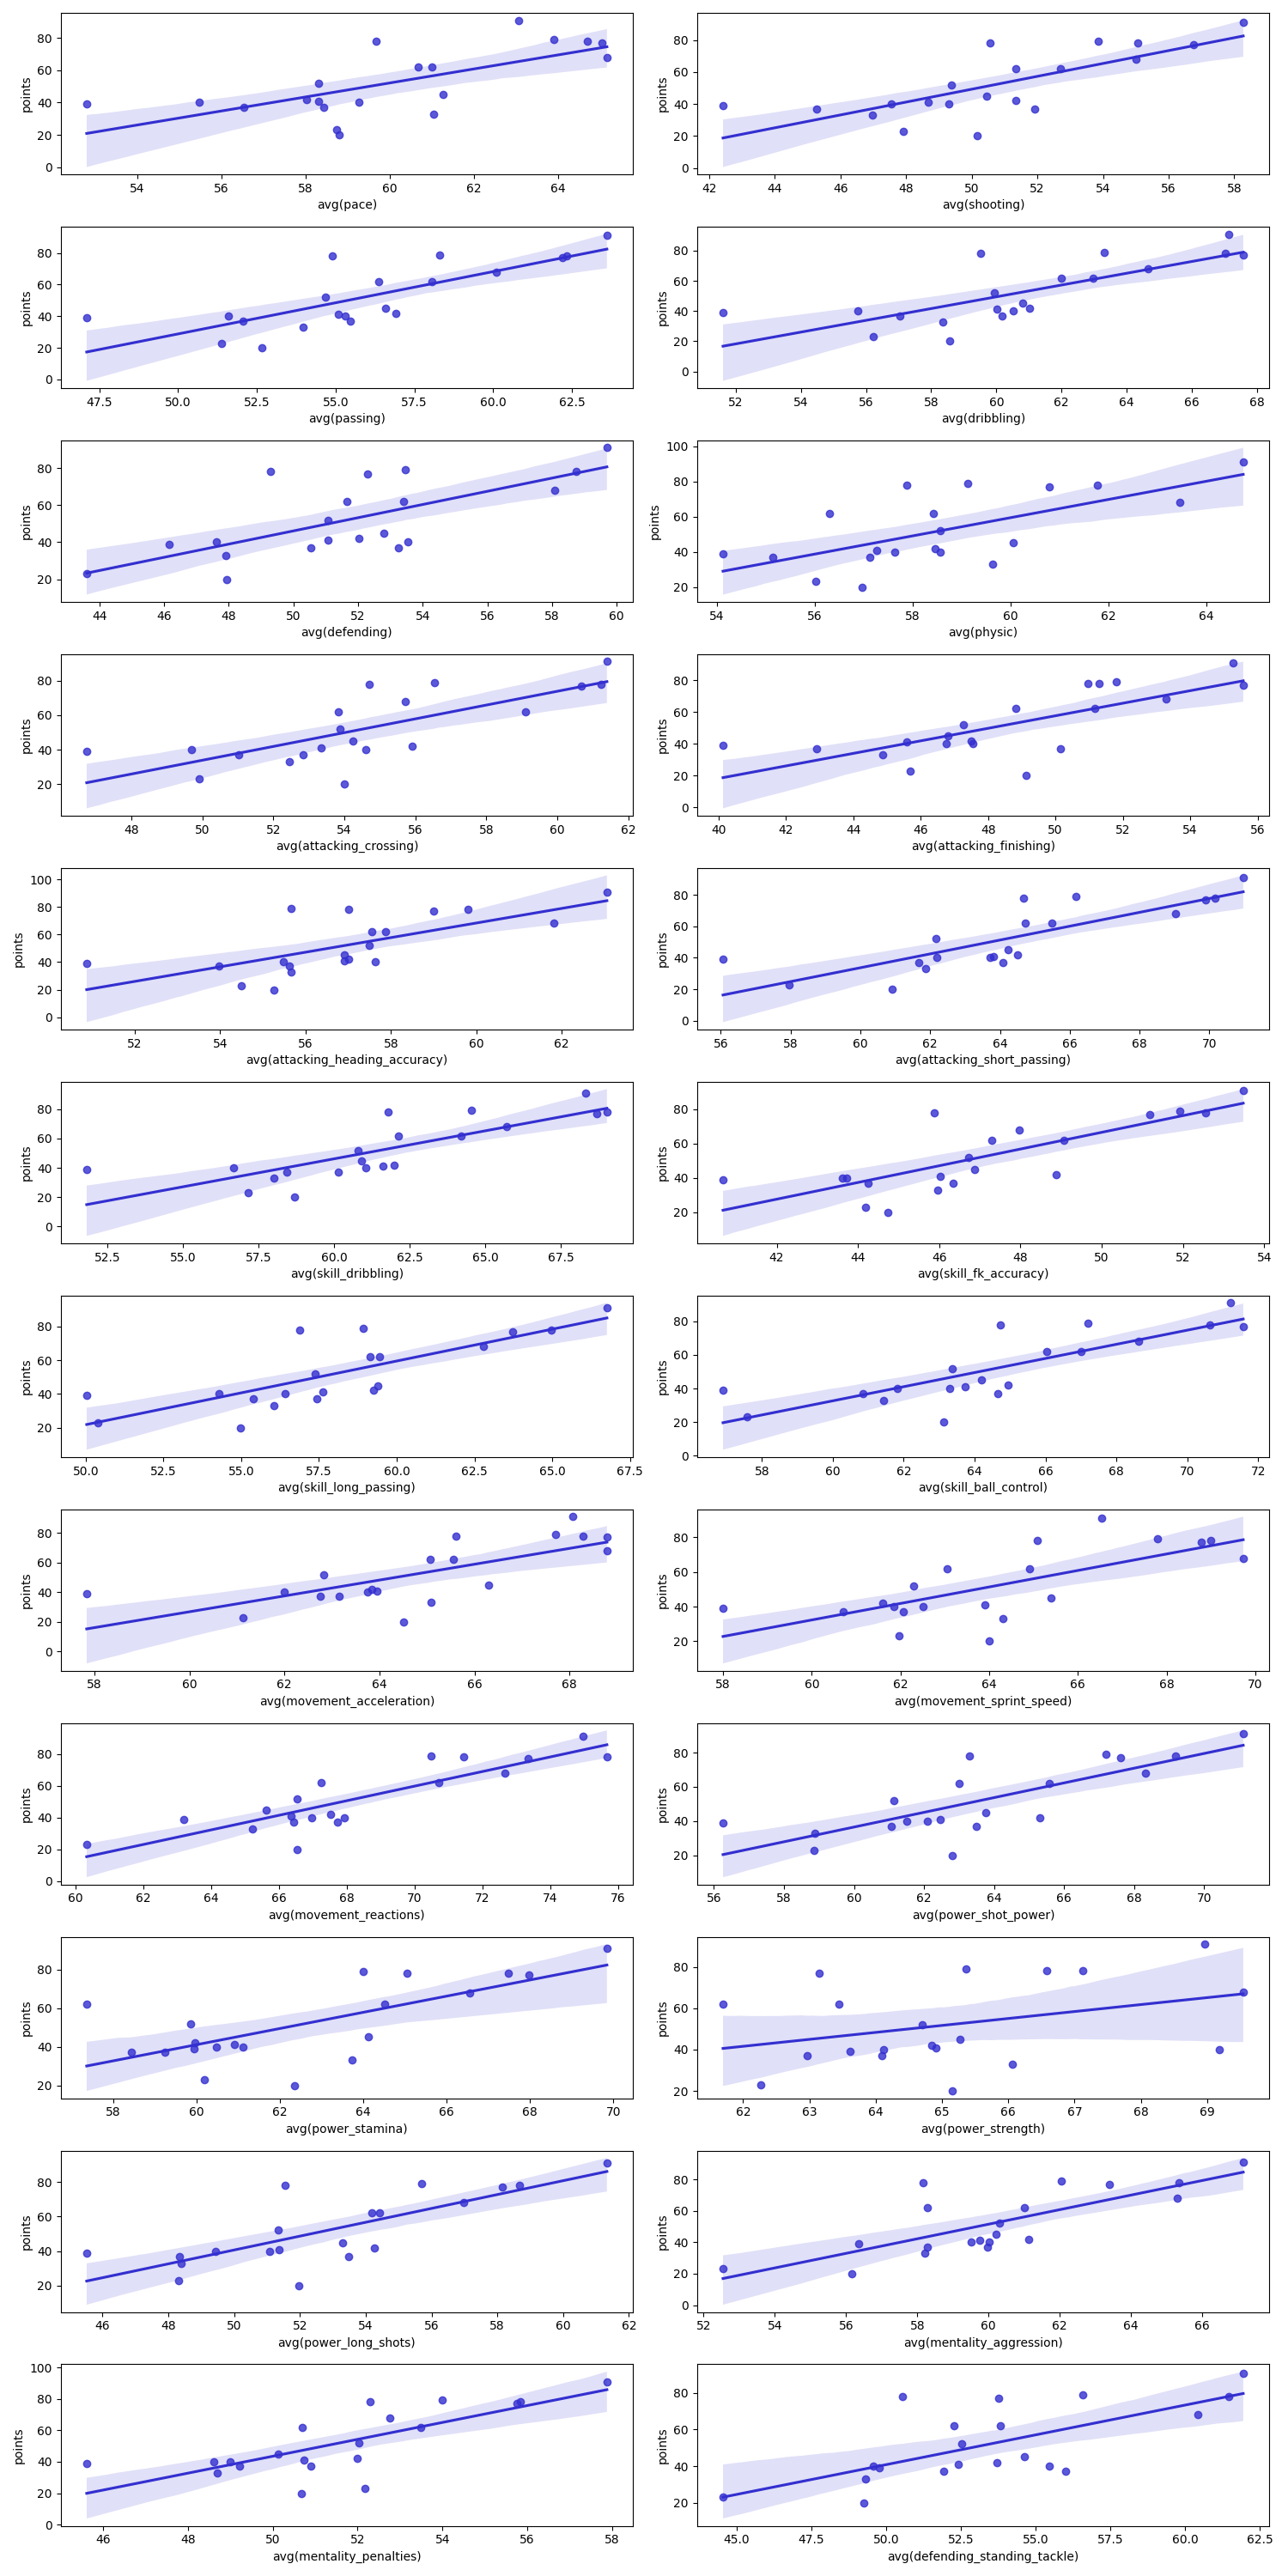

In [43]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES, TARGET_VARIABLE, color=COLOR_RAW
)

It can be observed that:

1. There is a general phenomenon of linear relation between each feature and the final points.
2. There is a generalized high variance across all features.
   1. E.g. taking the very last feature (`avg(defending_standing_tackle`), players with a value close to `50` result to a wide range of points.
   2. On the contrary, in extreme values (close to `40` or `90`), the resulting variable have a narrower range.

### Feature distribution

The following plot shows the distribution of the player features in the analyzed dataframe.

/tmp/ipykernel_26366/3179338471.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)


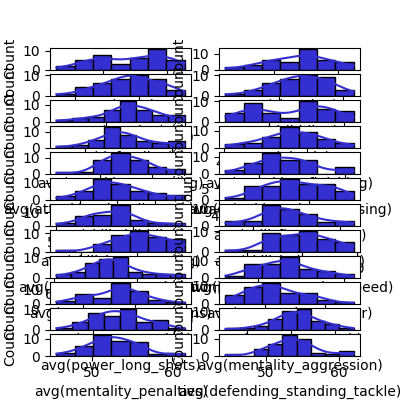

In [44]:
plot_feature_distribution(pdf, ALL_FEATURES, color = COLOR_RAW)

From the plot it is possible to observe that:

1. Most features have a symmetrical distribution.
2. Most features are centered around the middle.
3. Some features are more skewed towards left, hinting that they may be more "rare".
4. Some features don't properly follow a Gaussian distribution (`avg(pace)`, `avg(physic)`).

Furthermore, observation `2` is linked to the observation `2.2` of the previous plot:

* A lot of features have an average value.
* Around the average values, there is high variance.

Hence, most likely, the system will be exposed multiple times to this issue, affecting performances.

### Pearson Correlation Matrix

The **Pearson's Correlation Matrix** is a graphical tool to show a numerical value indicating the correlation between each variable.

It is employed in the project, to find whether some features are correlated to each other, which can either be a problem for Linear Regression, but not so much for Tree-based models, since they by design perform a feature selection step.

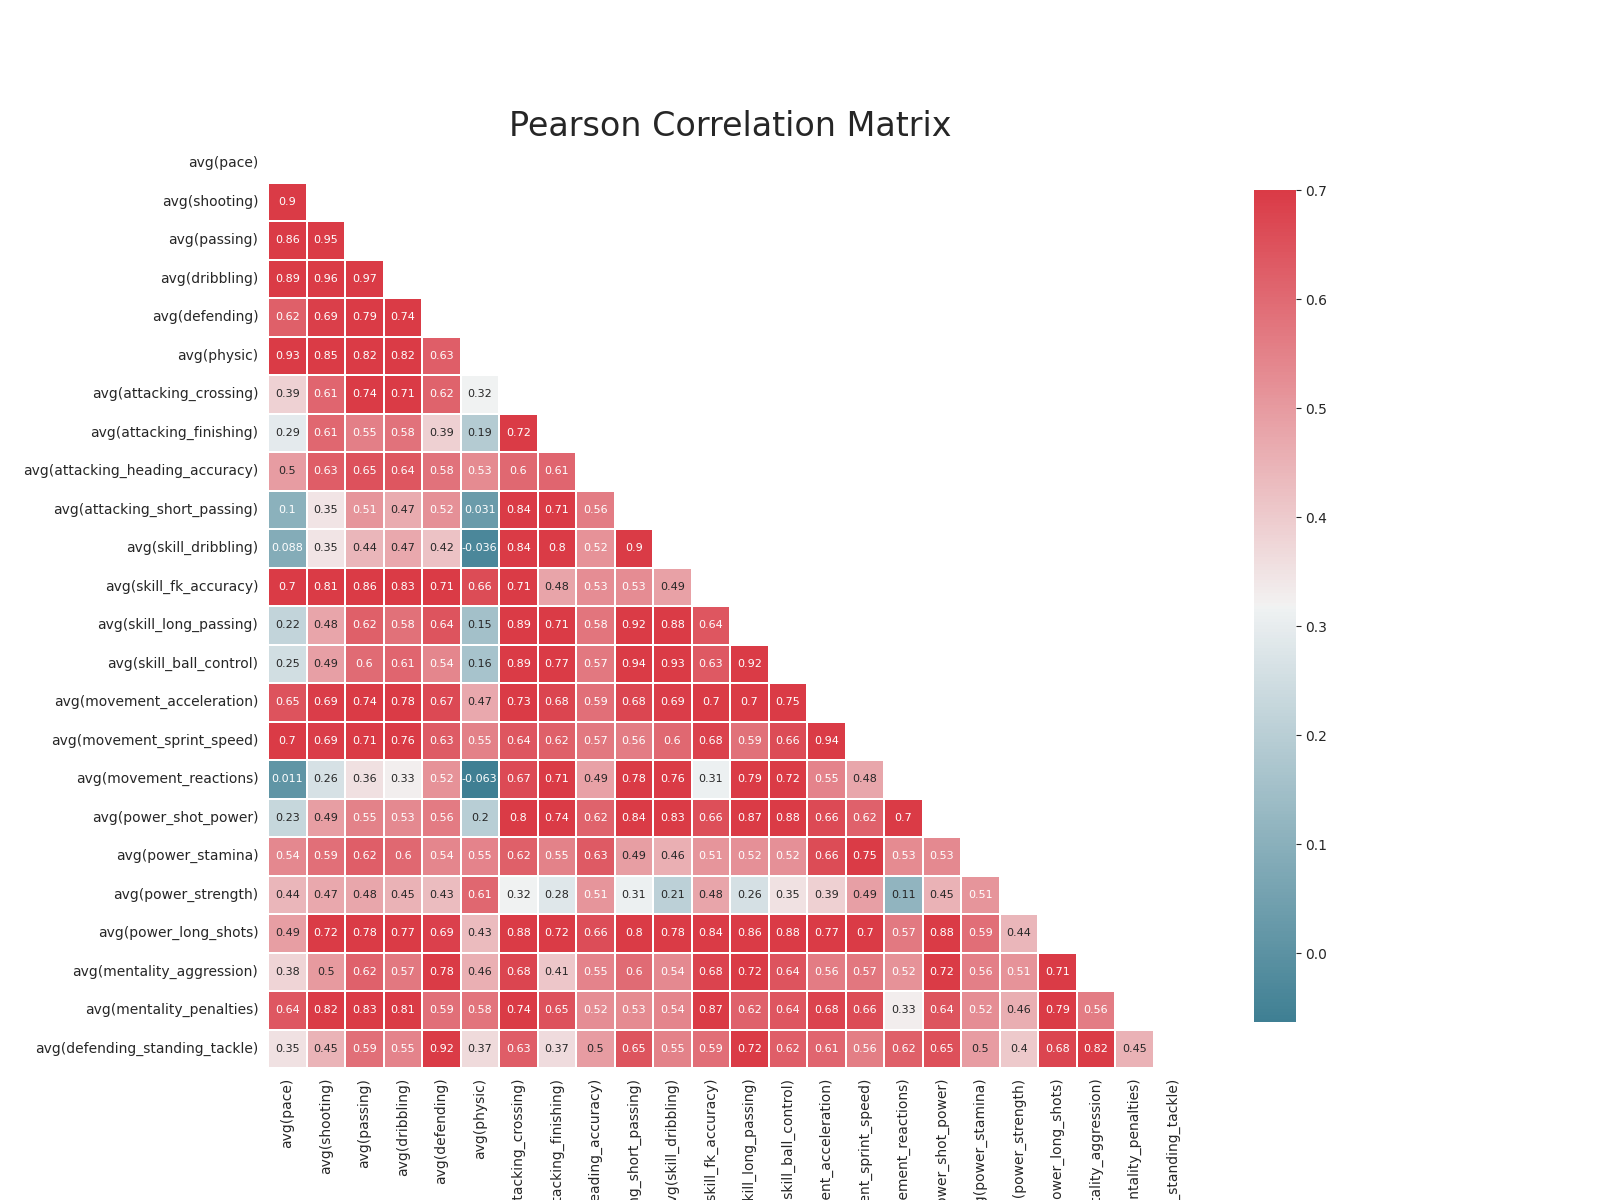

In [45]:
plot_correlation_matrix(pdf, ALL_FEATURES)

There are:

* A lot of positive correlations (red).
* Some negative correlations (teal).
* Some feature are tendentially not correlated to others (white).

Using some domain knowledge, it is possible to further comment some correlations, like (among others):

* The more a defender is good, the more aggressive they are.
* The more a defender is good, the more able to perform standing tackles they are.
* The more a player has good physical strenght, the more fast (pace) they are.

## Standardization

Since we have some features with skewed distributions, it is needed to standardize, to see whether it helps to center feature distribution.

In [46]:
# standardized_df = df

It is needed to define a scaler which takes feature from `all_vec` and places scaled versions in `all_vec_std`.

The configuration is of a standard z-score normalization.

In [47]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="all_vec", 
    outputCol="all_vec_std", 
    withStd=True, 
    withMean=True
)

df = scaler.fit(df).transform(df)

In [48]:
COLOR_STD = "#9254C8"

ALL_FEATURES_STD = [
    player_feature + "_std" for player_feature in ALL_FEATURES
]

In [49]:
pdf = df.toPandas()

Since the scaler grouped all features in a single field (feature vector), but plotting requires using different fields (one per features), it is needed to define a function to extract each feature and place it in a separate column.

In [50]:
def feature_vec_to_cols(pdf, vec, columns):
    tmp = pdf.reindex(
        columns=list(pdf.columns) + columns
    )

    tmp[columns] = tmp[
        vec
    ].transform(
        {
            columns[i]: operator.itemgetter(i) for i, p in enumerate(columns)
        }
    )
    return tmp

In [51]:
pdf = feature_vec_to_cols(pdf, "all_vec_std", ALL_FEATURES_STD)

It is possible to see the effects of the function by looking at the columns list.

In [52]:
pdf.columns

Index(['season', 'club_name', 'avg(attacking_short_passing)', 'avg(shooting)',
       'avg(power_stamina)', 'avg(skill_long_passing)', 'avg(power_strength)',
       'avg(defending_standing_tackle)', 'avg(skill_fk_accuracy)',
       'avg(skill_dribbling)', 'avg(dribbling)', 'avg(pace)',
       'avg(mentality_aggression)', 'avg(movement_reactions)',
       'avg(movement_sprint_speed)', 'avg(passing)',
       'avg(movement_acceleration)', 'avg(attacking_heading_accuracy)',
       'avg(attacking_finishing)', 'avg(defending)', 'avg(attacking_crossing)',
       'avg(power_long_shots)', 'avg(mentality_penalties)', 'avg(overall)',
       'avg(power_shot_power)', 'avg(value)', 'avg(physic)',
       'avg(skill_ball_control)', 'league', 'points', 'place', 'all_vec',
       'all_vec_std', 'avg(pace)_std', 'avg(shooting)_std', 'avg(passing)_std',
       'avg(dribbling)_std', 'avg(defending)_std', 'avg(physic)_std',
       'avg(attacking_crossing)_std', 'avg(attacking_finishing)_std',
       'avg(at

### Feature-target correlation

As done in the _raw data_ section, a feature-target correlation analysis is performed.

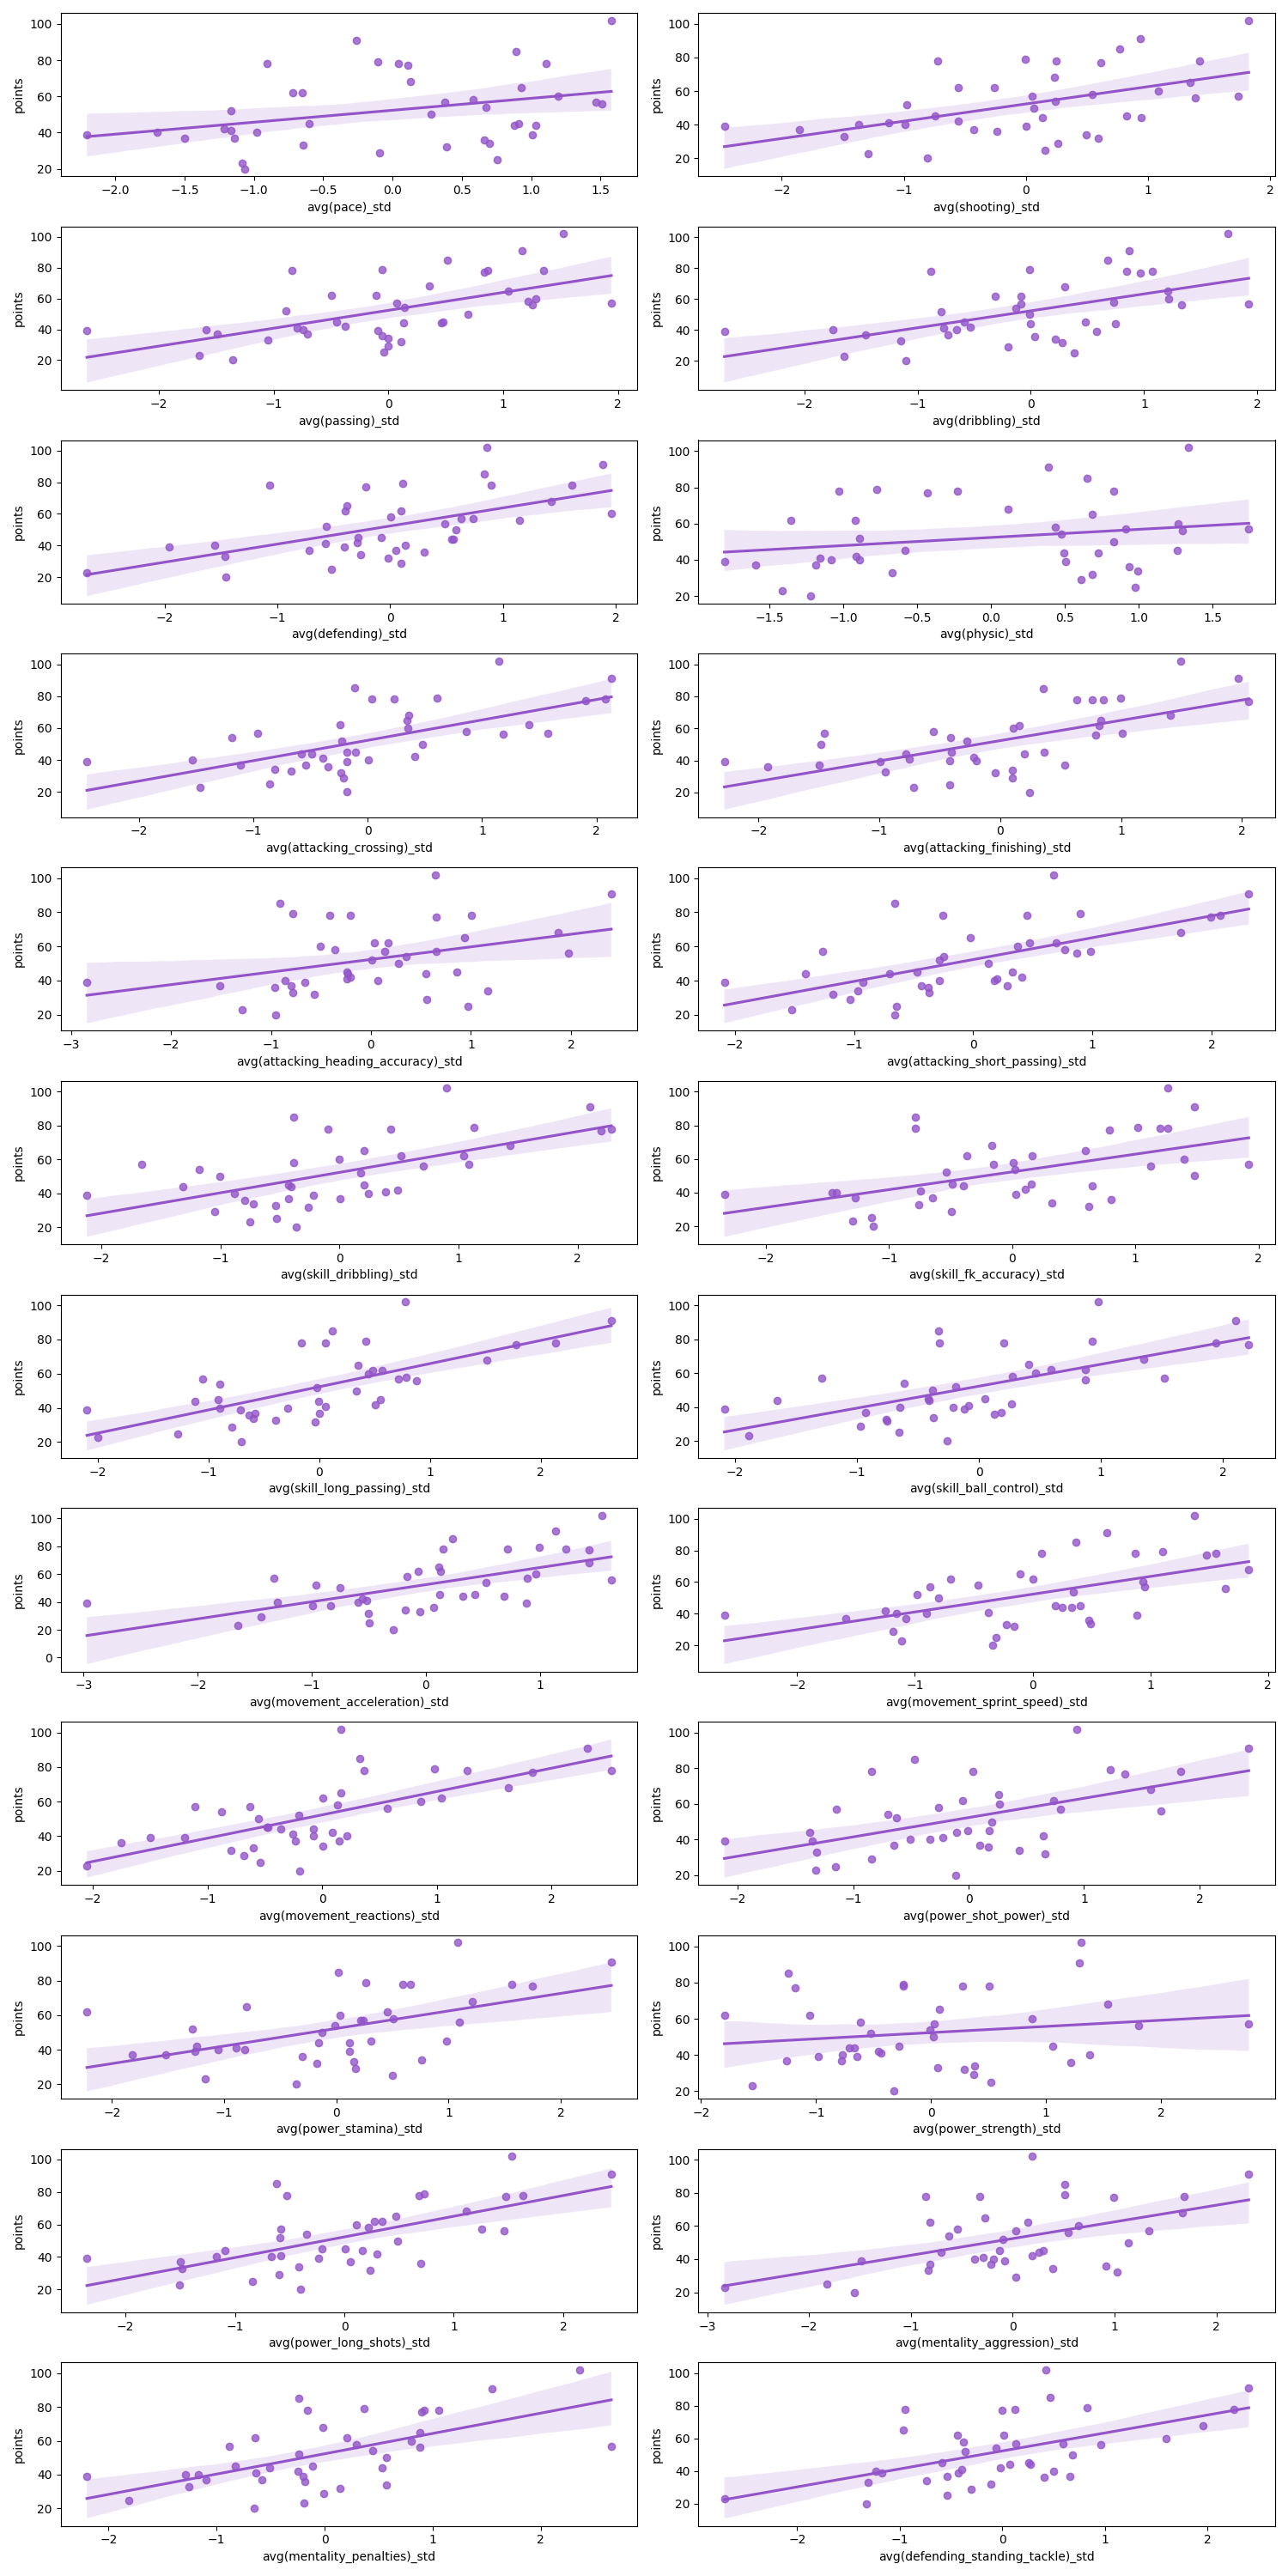

In [53]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_STD, TARGET_VARIABLE, color=COLOR_STD
)

Let's again zoom on a single season.

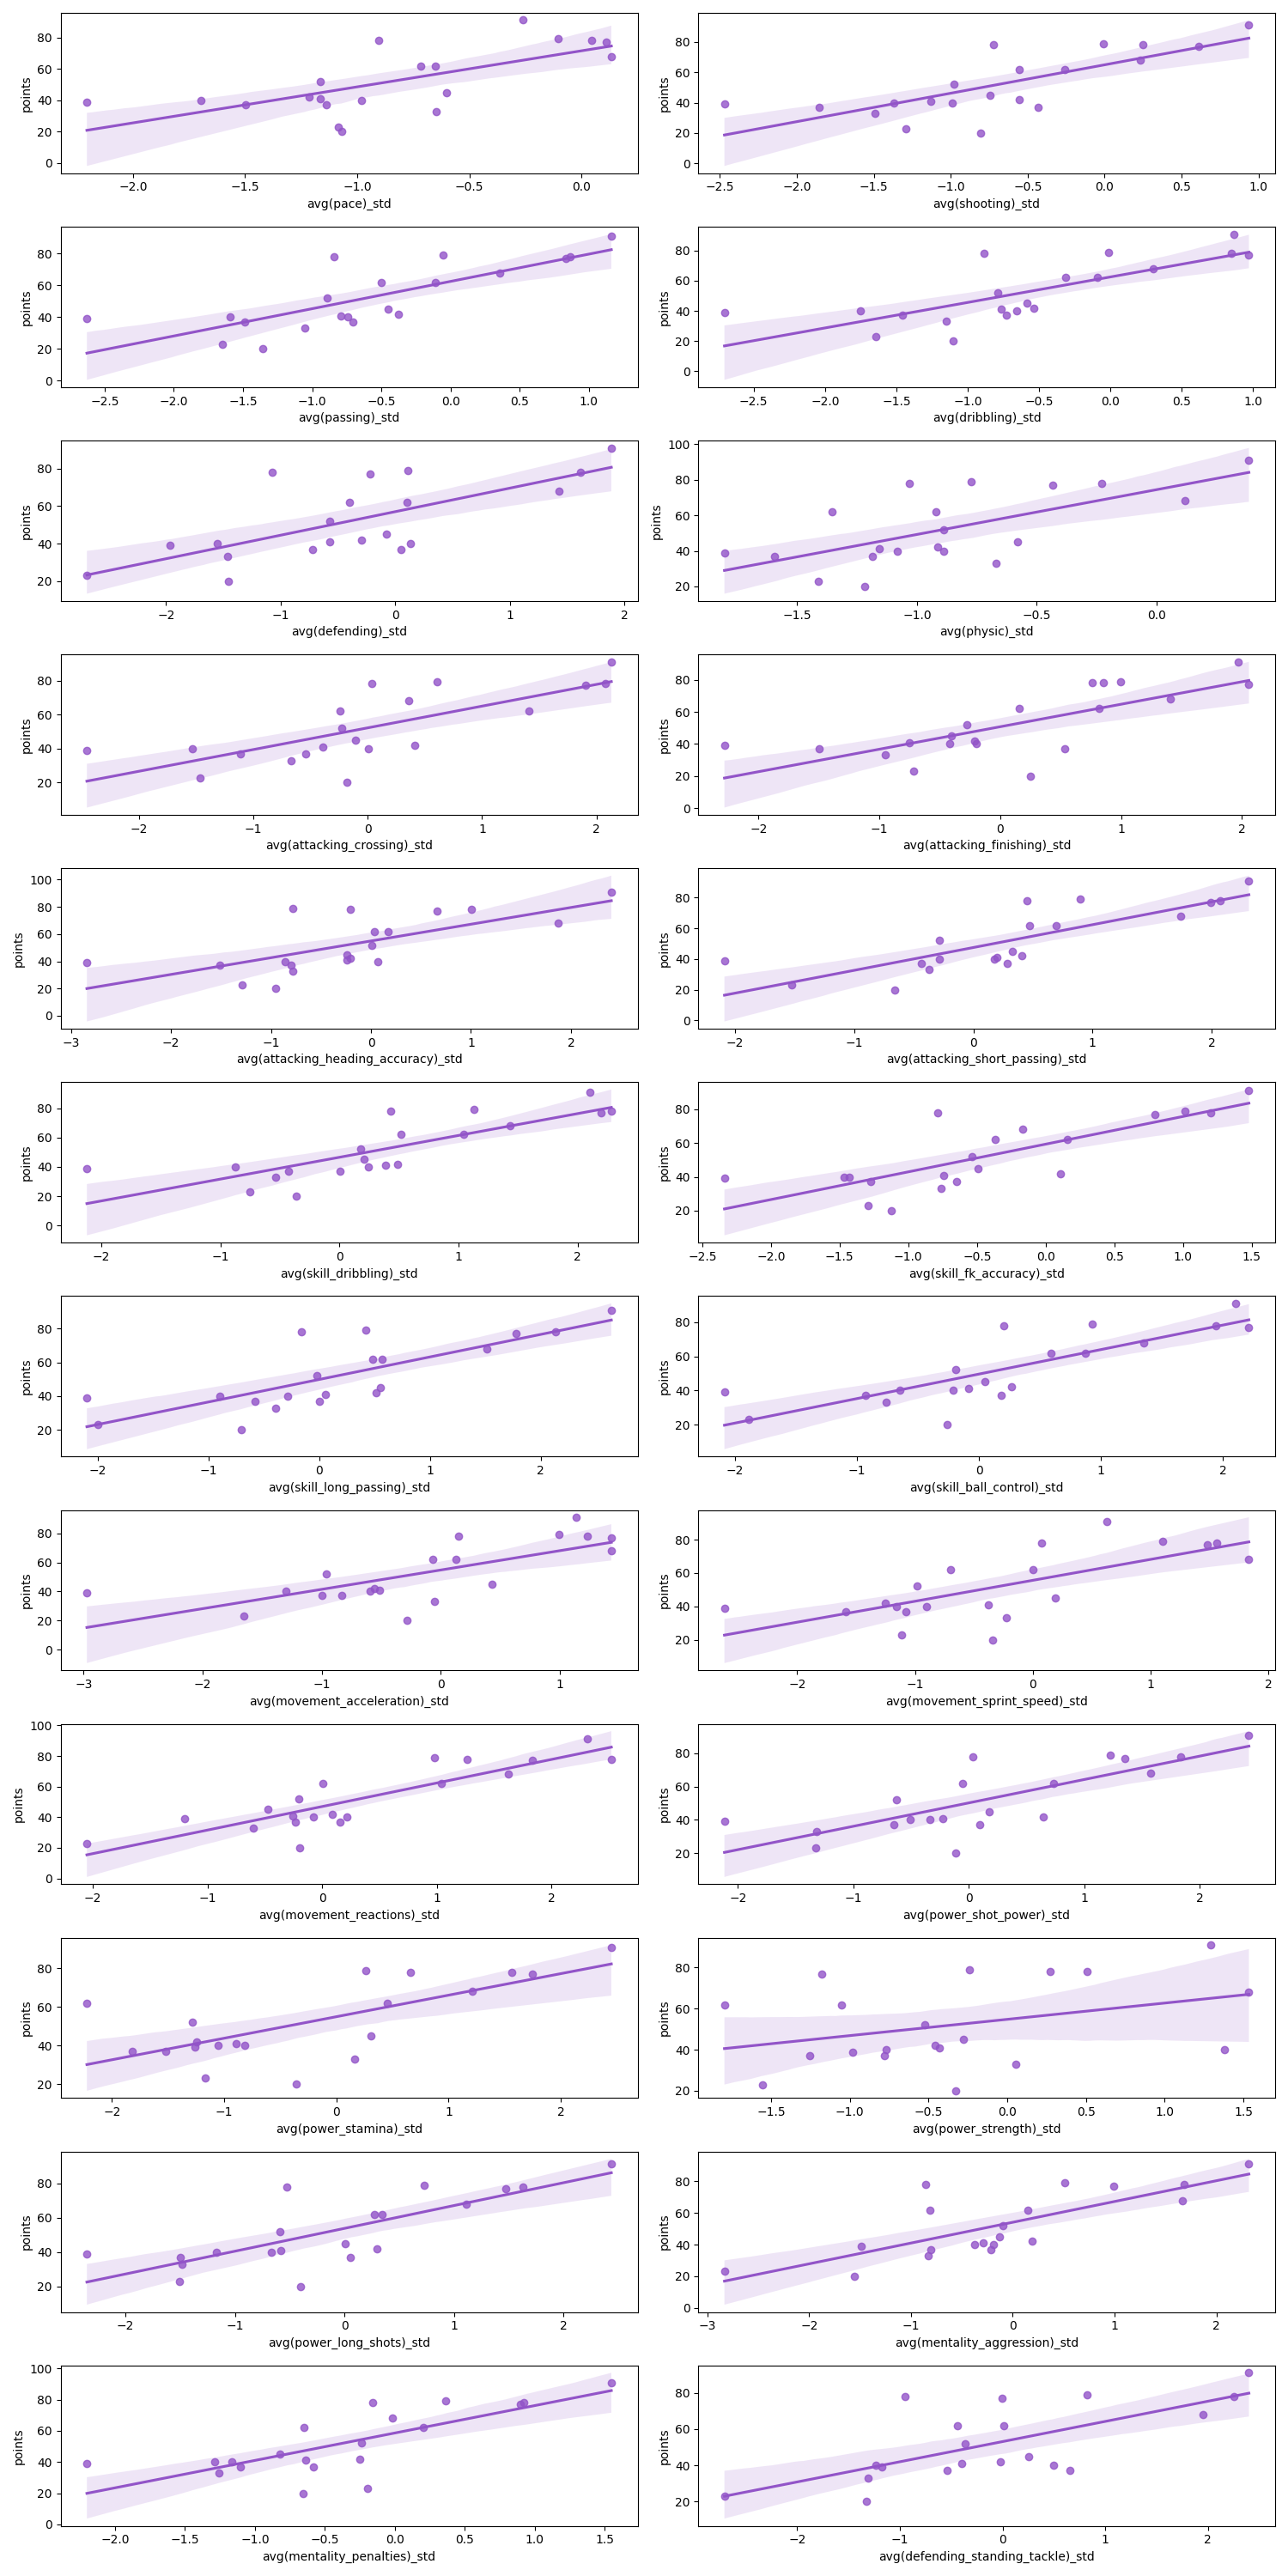

In [54]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_STD, TARGET_VARIABLE, color=COLOR_STD
)

Standardization does not improve the variance issue.

#### Feature distribution

/tmp/ipykernel_26366/3179338471.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)


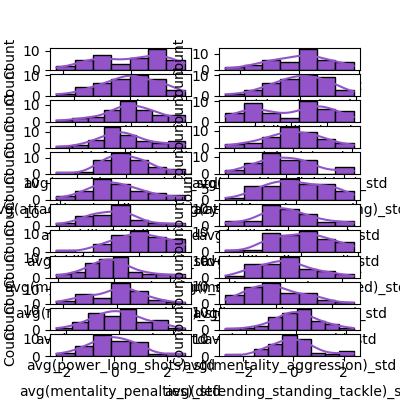

In [55]:
plot_feature_distribution(
    pdf, ALL_FEATURES_STD, color = COLOR_STD
)

Standardization did not change the feature distribution.

It is not needed to plot the correlation matrix again, since it is not affected by a change of scale.

## Log transformation

A further attempt consists of apply Logarithmic Transformation, still trying to combat skewness.

In [56]:
COLOR_LOG = "#E15FED"
ALL_FEATURES_LOG = [
    player_feature + "_log" for player_feature in ALL_FEATURES
]


The following function translates a value to its $log_2$.

In [57]:
to_log_UDF = udf(
    lambda value: float(np.log2(value)), DoubleType()
)

In [58]:
for feature, feature_log in zip(ALL_FEATURES, ALL_FEATURES_LOG):
    df = df.withColumn(feature_log, to_log_UDF(col(feature)))

df = df.withColumn("points_log", to_log_UDF(col("points")))

In [59]:
pdf = df.toPandas()

### Feature-target correlation

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_LOG, "points_log", color=COLOR_LOG
)

Also Logarithmic transformation did not help with the variance problem.

Let's again see a zommed version.

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_LOG, "points_log", color=COLOR_LOG
)

Logarithmic transformation did not help with variance.

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_LOG, color = COLOR_LOG)

Logarithmic transformation slightly moved the skewdness of all features towards right, still not solving it; as a consequence, centered or right-skewed features are not slightly worsened.

## Min-max transformation

In [63]:
COLOR_MIN_MAX = "#6EDCD9"
ALL_FEATURES_MIN_MAX = [
    player_feature + "_min_max" for player_feature in ALL_FEATURES
]


In [64]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(
    inputCol="all_vec", 
    outputCol="all_vec_min_max"
)

df = scaler.fit(df).transform(df)

In [65]:
pdf = df.toPandas()
pdf = feature_vec_to_cols(pdf, vec="all_vec_min_max", columns=ALL_FEATURES_MIN_MAX)

### Feature-target relationship

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, color=COLOR_MIN_MAX
)

Zoomed view:

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, color=COLOR_MIN_MAX
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_MIN_MAX, color=COLOR_MIN_MAX)

The following GIF compares the previously plotted feature distributions.

![GIF changes illustration](https://s8.gifyu.com/images/ezgif.com-gif-maker4847ef0cb3270edd.gif)

Before learning, some further useful visualizations are given.

**From now on, Min-Max transofrmed data will be used.**

## PCA (on min-max normalized data)

In [69]:
from pyspark.ml.feature import PCA

PCA_NUM_COMPONENTS = 2

def perform_pca(df, num_components, input_col, output_col):
    pca = PCA(
        k=num_components, 
        inputCol=input_col, 
        outputCol=output_col
    )
    pca_model = pca.fit(df)

    return pca_model.transform(df), pca_model

In [70]:
def plot_pca_explained_variance(pca_model, num_components_to_plot=2, figsize=(8,6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    _ = sns.barplot(
        x=[i for i in range(num_components_to_plot)],
        y=pca_model.explainedVariance.values[0:num_components_to_plot],
        ax=ax,
        palette="summer"
    )

    _ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
    _ = ax.set_ylabel("Proportion of Variance", fontsize=16)
    _ = ax.set_xticklabels(
        [f"Principal Component {i}" for i in range(num_components_to_plot)], 
        rotation=0
    )
    _ = ax.set_title("Explained variance of each Principal Component")

Actual PCA:

In [71]:
df, pca_model = perform_pca(
    df=df,
    num_components=PCA_NUM_COMPONENTS,
    input_col="all_vec_min_max",
    output_col="all_vec_min_max_pcs"
)

In [ ]:
plot_pca_explained_variance(
    pca_model=pca_model
)

#### Visualization

In [73]:
pdf = df.toPandas()

In [74]:
def scatter_plot(x, y, x_label, y_label, title="", c=None, c_map=plt.cm.get_cmap("tab10"), figsize=(12,8)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    _ = plt.scatter(
        x=x,
        y=y,
        c=y if c is None else c,
        edgecolor="none",
        #alpha=1,
        cmap=c_map,
        axes=ax,
    )

    _ = ax.set_xlabel(x_label, labelpad=20, fontsize=16)
    _ = ax.set_ylabel(y_label, fontsize=16)
    _ = ax.set_title(title)

    plt.colorbar()
    plt.show()

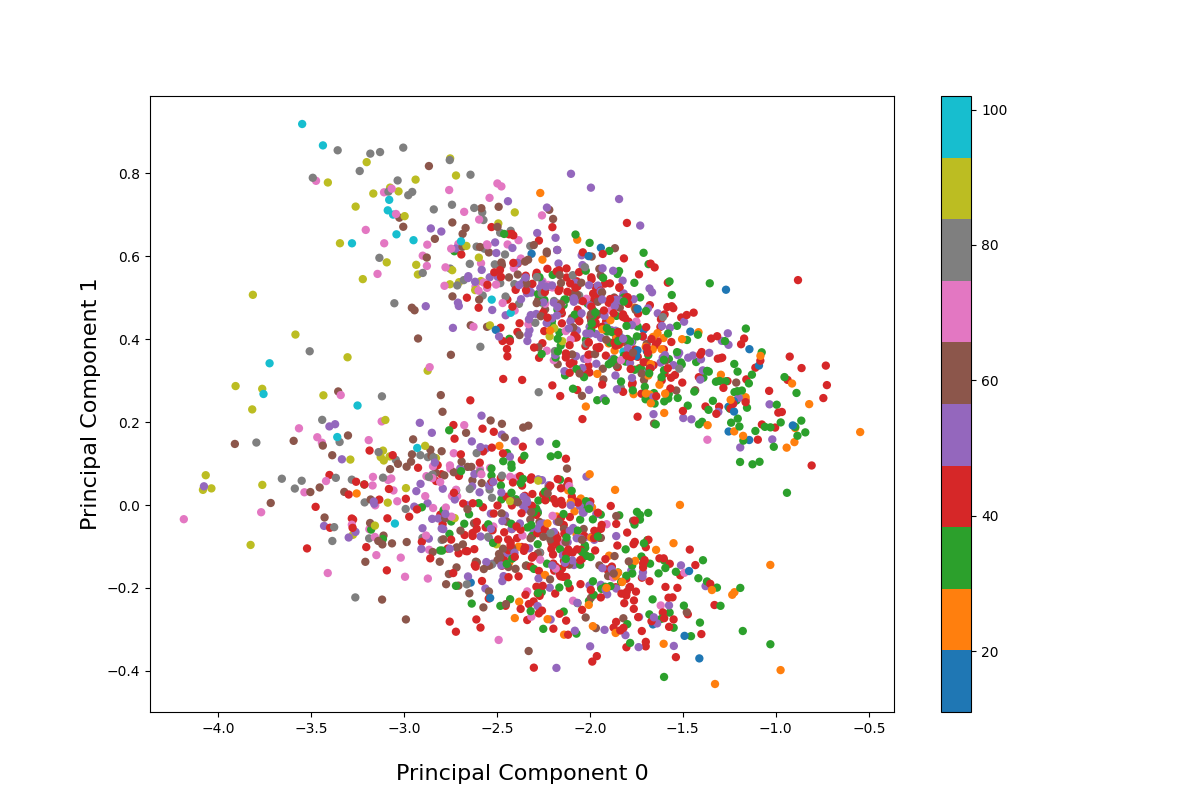

In [75]:
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    y=pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    c=pdf.points,
    x_label="Principal Component 0",
    y_label="Principal Component 1",
)  

PCA result is quite underwhelming: teams with widely different end-of-the-season placement tend to be mixed-up.

Notice that Principal Component Analysis is a linear model, so it is bounded to produce linear representations: usually, non-trivial problems present non-linear data.

For this reason, adding some non-linearity may possibly lead to a better lower-dimensional embedding...

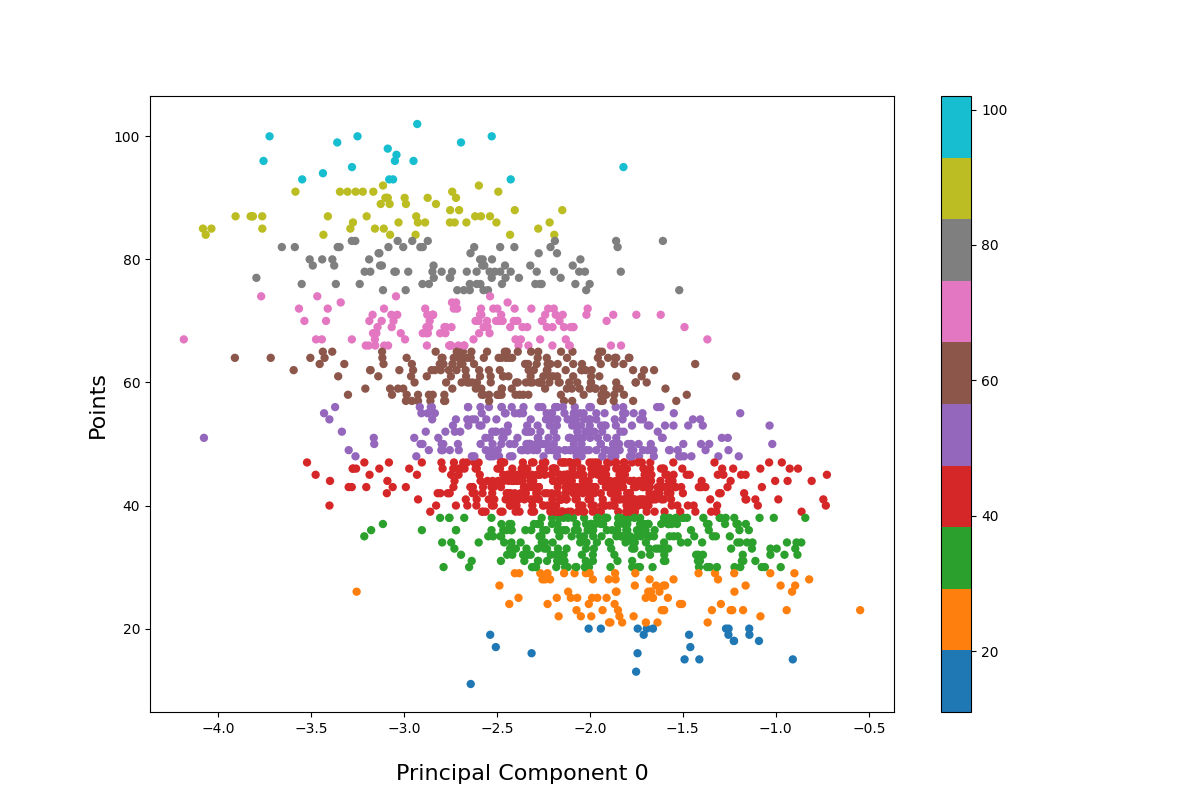

/tmp/ipykernel_49116/2175090070.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize)


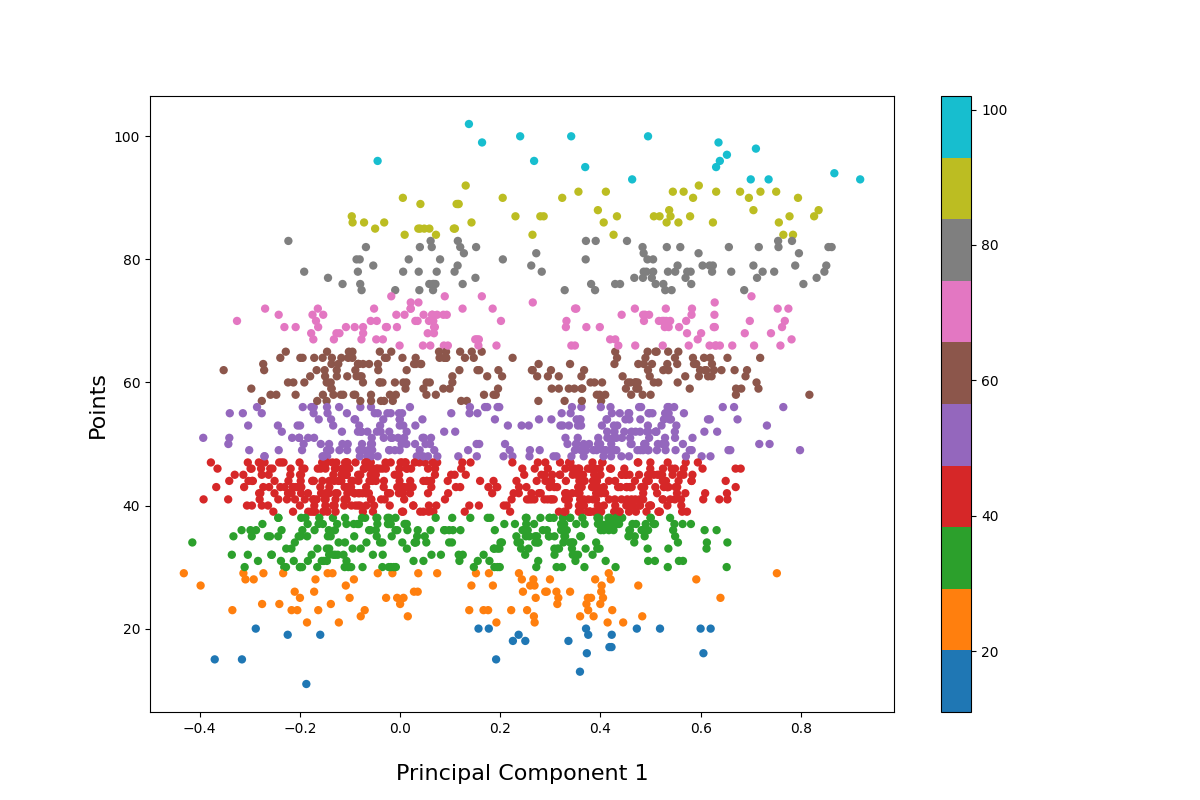

In [76]:
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    y=pdf.points,
    x_label="Principal Component 0",
    y_label="Points",
)
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    y=pdf.points,
    x_label="Principal Component 1",
    y_label="Points",
)

## t-SNE

t-SNE is one of the most used tools, when assuming non-linearity in the data space.

Implementation from SciKit Learn framework will be used, since PySpark does not provide any version of this tool.

SciKit Learn works with NumPy structures, so the feature vector in PySpark DataFrame must be converted to a NDArray structure.

In [39]:
all_vec_min_max_np = np.array(
    list(
        map(
            lambda v: v["all_vec_min_max"].toArray(), 
            df.select("all_vec_min_max").collect()
        )
    )
)

points_np = np.array(
    list(
        map(
            lambda v: v["points"], 
            df.collect()
        )
    )
).reshape(-1)

Once data is ready, TNSE is called.

In [78]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(
    n_components=2, learning_rate='auto', init='random', method="barnes_hut"
).fit_transform(all_vec_min_max_np)

And, once the embedding space is populated, the result is plotted

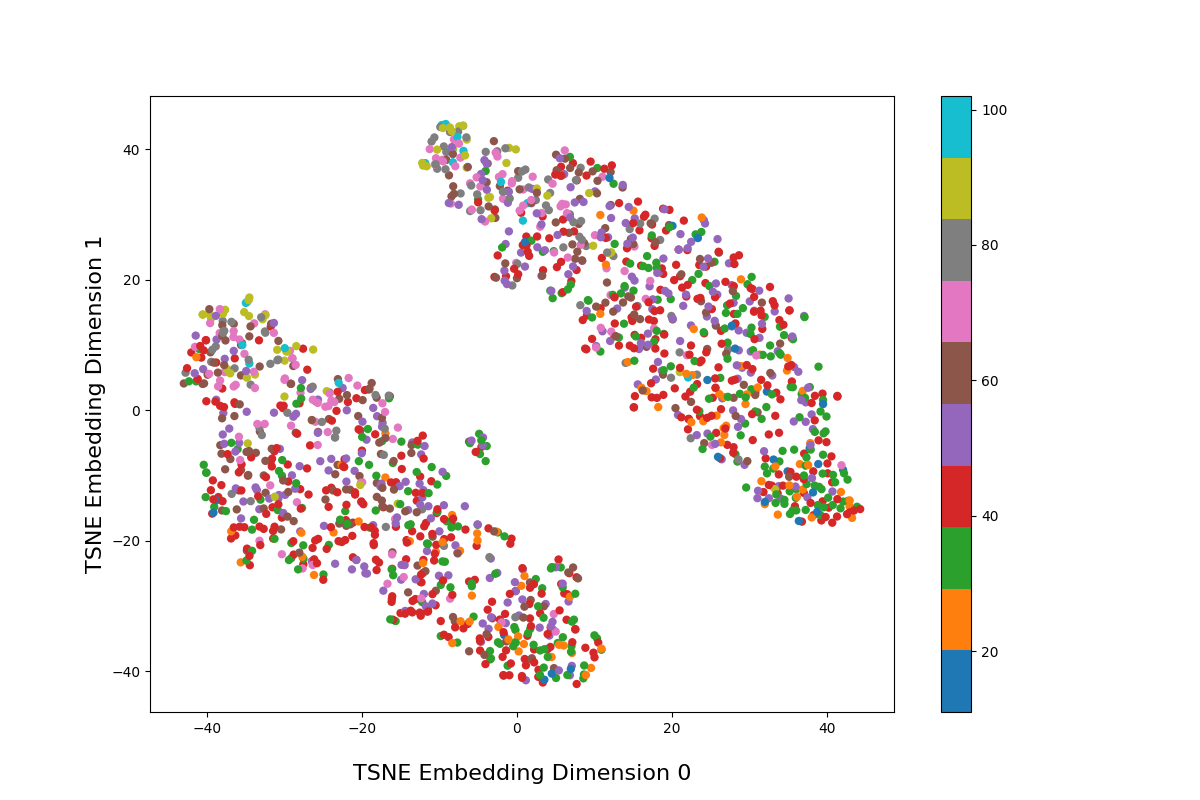

In [79]:
scatter_plot(
    x=tsne_embedding[:,0],
    y=tsne_embedding[:,1],
    c=points_np,
    x_label="TSNE Embedding Dimension 0",
    y_label="TSNE Embedding Dimension 1",
)

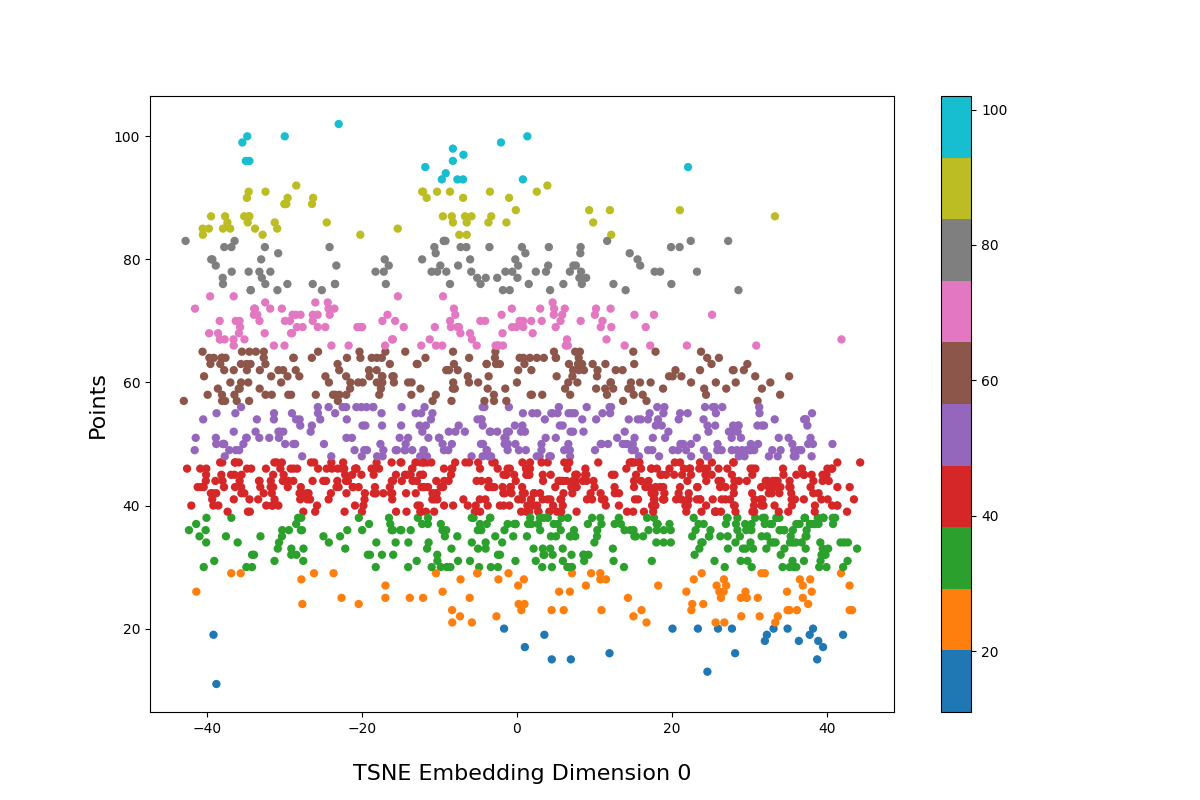

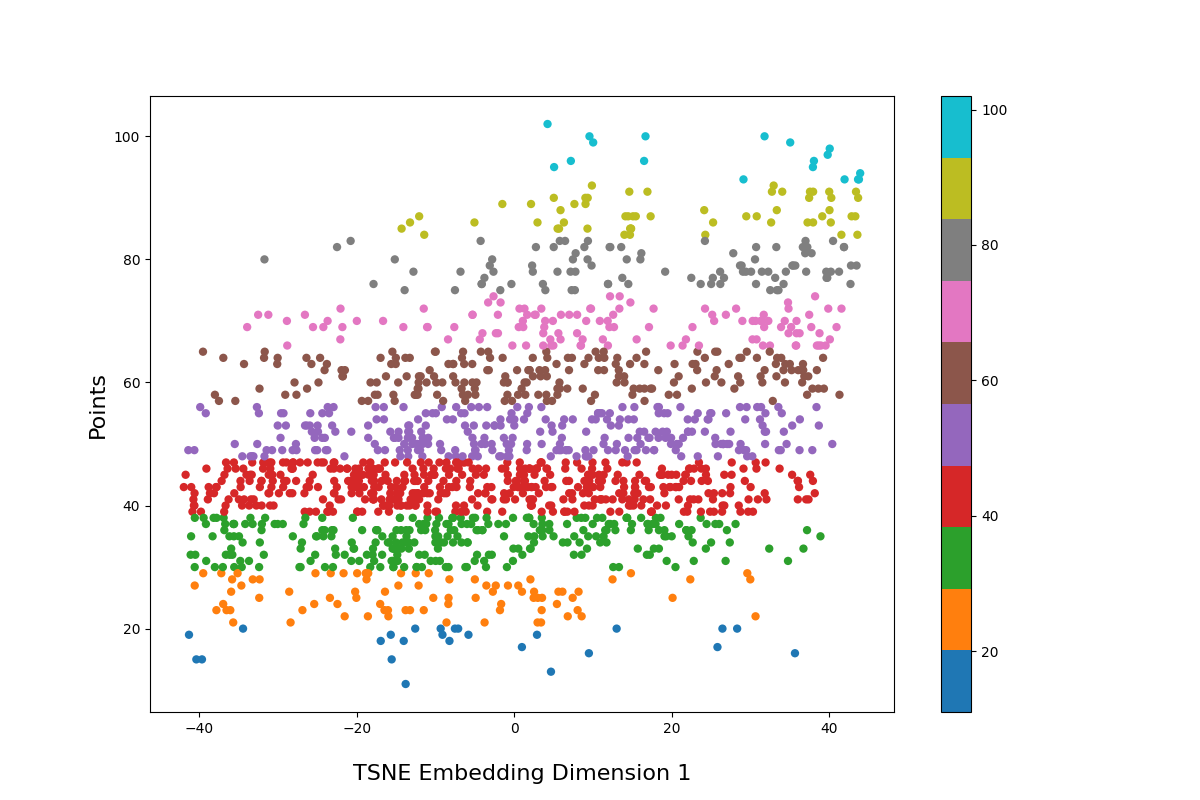

In [80]:
scatter_plot(
    x=tsne_embedding[:,0],
    y=points_np,
    x_label="TSNE Embedding Dimension 0",
    y_label="Points",
)
scatter_plot(
    x=tsne_embedding[:,1],
    y=points_np,
    x_label="TSNE Embedding Dimension 1",
    y_label="Points",
)

Unfortunately, adding non-linearity does not seem to improve the situation.

Not much progress has been made, w.r.t. PCA 

[TODO] comment on variance

## Comments on visualizations

Data seems to be:

* Not linearly separable.
* Suffering from high variance.
* ...

## Learning

The problem has been treated in two different forms:

* As **regression** on the **points**.
* As **classification** on the table/ranking areas (macro places).

In both cases, for all the different models will be used:

* **K-Fold Cross Validation**, to perform validation tests on the model performances.
* **Grid-search approach**, to perform hyperparameter tuning.

In [75]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import Regressor
from pyspark.ml.classification import Classifier
from pyspark.ml.classification import OneVsRest

from pyspark.ml.regression import RegressionModel
from pyspark.ml.classification import ClassificationModel

In [76]:
def learn_best_model(estimator, param_grid, feature_vec, label_col, prediction_col):
    evaluators = dict()

    if isinstance(estimator, Regressor):
        evaluators = {
            metric: RegressionEvaluator(
                labelCol=label_col,
                predictionCol=prediction_col,
                metricName=metric,
            )
            for metric in evaluation_metrics
        }
    elif isinstance(estimator, Classifier) or isinstance(estimator, OneVsRest):
        evaluators = {
            metric: MulticlassClassificationEvaluator(
                labelCol=label_col,
                predictionCol=prediction_col,
                metricName=metric,
            )
            for metric in evaluation_metrics
        }
    else:
        raise Exception("Unexpected estimator, got" + str(type(estimator)))

    cross_validations = {
        metric: CrossValidator(
            estimator=estimator,
            estimatorParamMaps=param_grid,
            evaluator=evaluators[metric],
            numFolds=5,
            collectSubModels=True
        )
        for metric in evaluation_metrics_cv
    }

    cross_validated_models = dict()

    for metric in evaluation_metrics_cv:
        cross_validated_models[metric] = cross_validations[
            metric
        ].fit(train_df)

    return cross_validated_models, evaluators

In [77]:
def evaluate_learning_models(cross_validated_models, regressor_evaluators):
    for metric in evaluation_metrics_cv:

        best_model = cross_validated_models[metric].bestModel
        has_summary = True
        
        try:
            has_summary = best_model.hasSummary
        except AttributeError as e:
            # since the only models that have summary
            # have the hasSummary field,
            # it is needed to catch this exception
            has_summary = False
        
        if has_summary:
            training_result = best_model.summary
            
            if best_model.isinstance(RegressionModel):
                print(
                    f"""
                    Training set evaluation
                    {type(best_model).__name__}
                    Best model according to metric: {metric}
                    \tRMSE:        {builtins.round(training_result.rootMeanSquaredError, 2)}
                    \tR2:          {builtins.round(training_result.r2, 2)}
                    \tAdjusted R2: {builtins.round(training_result.r2adj, 2)}
                    """
                )
            else:
                print(
                    f"""
                    Training set evaluation
                    {type(best_model).__name__}
                    Best model according to metric: {metric}
                    \tAccuracy: {builtins.round(training_result.accuracy, 2)}
                    \tF1:       {builtins.round(training_result.f1, 2)}
                    """
                )

            predictions = {
                metric: cross_validated_models[
                    metric
                ].bestModel.transform(test_df)
                for metric in evaluation_metrics_cv
            }

            for m, model in cross_validated_models.items():
                print(
                f"""
                Test set evaluation
                {type(best_model).__name__}
                Best model according to metric {m}
                """
                )

                for e, evaluator in regressor_evaluators.items():
                    print(f"{evaluator.getMetricName()}: {evaluator.evaluate(predictions[m])}")

        else: # no summary available
            for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
                predictions = {
                    metric: best_model.transform(stage_df)
                    for metric in evaluation_metrics_cv
                }

                for m, model in cross_validated_models.items():
                    print(
                        f"""{stage_name} set evaluation
                        {type(model).__name__}
                        Best model elected by {m}"""
                    )

                    for e, evaluator in regressor_evaluators.items():
                        print(f"{evaluator.getMetricName()}: {evaluator.evaluate(predictions[m])}")


### Regression

In [146]:
train_df, test_df = df.randomSplit([0.7, 0.3])

# TODO make upper case
evaluation_metrics = ["r2", "mse"]
evaluation_metrics_cv = ["r2"]

#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

FEATURES_COL = "all_vec_min_max"
LABEL_COL = "points"
PREDICTION_COL = "lr_predictions"

estimator = LinearRegression()

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    # .addGrid(lr_raw.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
    # .addGrid(lr_raw.solver, ["auto", "normal", "l-bfgs"])
    # .addGrid(lr_raw.standardization, [True, False])
    # .addGrid(lr_raw.loss, ["squaredError", "huber"])
    # huber loss does NOT support ElasticNet Regularization :(
    # .addGrid(lr_raw.fitIntercept, [True, False])
    # .addGrid(lr_raw.elasticNetParam, [0.0, 0.25, 0.5, 1.0])
    .build()
)

cross_validated_models, evaluators = learn_best_model(
    estimator=estimator,
    param_grid=param_grid,
    feature_vec=[FEATURES_COL],
    label_col=LABEL_COL,
    prediction_col=PREDICTION_COL
)

In [141]:
evaluate_learning_models(cross_validated_models, evaluators)

Train set evaluation
                        Best model elected by r2


r2: 0.5456149267266714


mse: 121.4279660543379
Test set evaluation
                        Best model elected by r2


r2: 0.34497292977746064


mse: 186.08057551996083


#### Decision Tree Regression

In [132]:
from pyspark.ml.regression import DecisionTreeRegressor

PREDICTION_COL = "dtr_predictions"

estimator = DecisionTreeRegressor()

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    .addGrid(estimator.maxDepth, [2, 5, 10])
    .addGrid(estimator.maxBins, [16, 32, 64])
    .addGrid(estimator.minInfoGain, [0, 0.1])
    .build()
)

cross_validated_models, evaluators = learn_best_model(
    estimator=estimator,
    param_grid=param_grid,
    feature_vec=[FEATURES_COL],
    label_col=LABEL_COL,
    prediction_col=PREDICTION_COL
)

In [142]:
evaluate_learning_models(cross_validated_models, evaluators)

Train set evaluation
                        Best model elected by r2


r2: 0.5456149267266714


mse: 121.4279660543379
Test set evaluation
                        Best model elected by r2


r2: 0.34497292977746064


mse: 186.08057551996083


#### Gradient Boosted Tree Regression

In [143]:
from pyspark.ml.regression import GBTRegressor

PREDICTION_COL = "gbtr_predictions"

estimator = DecisionTreeRegressor()

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    # .addGrid(estimator.maxDepth, [2, 5, 10])
    # .addGrid(estimator.maxBins, [16, 32, 64])
    # .addGrid(estimator.minInfoGain, [0, 0.1])
    # .addGrid(estimator.subsamplingRate, [0.5, 1])
    # .addGrid(estimator.lossType, ["squared", "absolute"])
    .build()
)

cross_validated_models, evaluators = learn_best_model(
    estimator=estimator,
    param_grid=param_grid,
    feature_vec=[FEATURES_COL],
    label_col=LABEL_COL,
    prediction_col=PREDICTION_COL
)

In [144]:
evaluate_learning_models(cross_validated_models, evaluators)

Train set evaluation
                        Best model elected by r2


r2: 0.5456149267266714


mse: 121.4279660543379
Test set evaluation
                        Best model elected by r2


r2: 0.34497292977746064


mse: 186.08057551996083


#### Random Forest Regression

In [145]:
from pyspark.ml.regression import RandomForestRegressor

PREDICTION_COL = "rfr_predictions"

estimator = DecisionTreeRegressor()

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    # .addGrid(estimator.maxDepth, [2, 5, 10])
    # .addGrid(estimator.maxBins, [16, 32, 64])
    # .addGrid(estimator.minInfoGain, [0, 0.1])
    # .addGrid(estimator.subsamplingRate, [0.5, 1])
    # .addGrid(estimator.lossType, ["squared", "absolute"])
    # .addGrid(estimator.numTrees, [10, 20, 40])
    # .addGrid(estimator.featureSubsetStrategy, ["auto", "onethird", "all", "log2"])
    .build()
)

cross_validated_models, evaluators = learn_best_model(
    estimator=estimator,
    param_grid=param_grid,
    feature_vec=[FEATURES_COL],
    label_col=LABEL_COL,
    prediction_col=PREDICTION_COL
)

In [146]:
evaluate_learning_models(cross_validated_models, evaluators)

Train set evaluation
                        Best model elected by r2


r2: 0.5456149267266714


mse: 121.4279660543379
Test set evaluation
                        Best model elected by r2


r2: 0.34497292977746064


mse: 186.08057551996083


### Classification

#### Define macro places

The general idea of a macro place, is of a set of table partitioning.

In [78]:
NUM_MACRO_PLACES = 5

def get_macro_place(place, league, complex=False):
    def __naive(place, league):
        if league in ["Dutch Eredivisie", "German Bundesliga"]:
            if 1 <= place <= 3:
                return 0.0
            if 4 <= place <= 6:
                return 1.0
            if 7 <= place <= 10:
                return 2.0
            if 11 <= place <= 15:
                return 3.0
            if 16 <= place <= 18:
                return 4.0
        else:
            if 1 <= place <= 4:
                return 0.0
            if 5 <= place <= 8:
                return 1.0
            if 9 <= place <= 12:
                return 2.0
            if 13 <= place <= 16:
                return 3.0
            if 17 <= place <= 20:
                return 4.0

        return None

    def __complex(place, league):
        if league == "German Bundesliga":
            if 1 <= place <= 4:
                return 0.0
            if 5 <= place <= 7:
                return 1.0
            if 8 <= place <= 10:
                return 2.0
            if 11 <= place <= 15:
                return 3.0
            if 16 <= place <= 18:
                return 4.0

        if league == "Holland Eredivise":
            if place == 1:
                return 0.0
            if 2 <= place <= 3:
                return 1.0
            if 4 <= place <= 9:
                return 2.0
            if 10 <= place <= 15:
                return 3.0
            if 16 <= place <= 18:
                return 4.0

        if league == "French League 1":
            if 1 <= place <= 2:
                return 0.0
            if 3 <= place <= 5:
                return 1.0
            if 6 <= place <= 11:
                return 2.0
            if 12 <= place <= 17:
                return 3.0
            if 18 <= place <= 20:
                return  4.0
        
        else: #It, Sp, En
            if 1 <= place <= 4:
                return 0.0
            if 5 <= place <= 7:
                return 1.0
            if 8 <= place <= 12:
                return 2.0
            if 13 <= place <= 17:
                return 3.0
            if 18 <= place <= 20:
                return 4.0

        return None

    if complex:
        return __complex(place, league)

    return __naive(place, league)

get_macro_place_UDF = udf(
    lambda place, league, complex: get_macro_place(float(place), league, complex),
    DoubleType(),
)

In [79]:
df = df.withColumn(
    "macro_place_naive", get_macro_place_UDF(col("place"), col("league"), lit(False))
).withColumn(
    "macro_place_complex", get_macro_place_UDF(col("place"), col("league"), lit(True))
)

#### Continue with Classification

In [80]:
evaluation_metrics = ["accuracy", "f1"]
evaluation_metrics_cv = ["accuracy"]

train_df, test_df = df.randomSplit(
    [0.9,0.1]
    # [0.7, 0.3]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
)

#### Visualizations

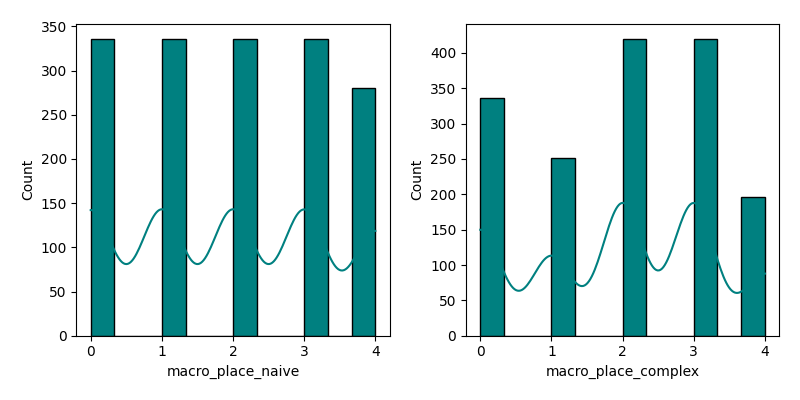

In [137]:
plot_feature_distribution(
    df.toPandas(), 
    ["macro_place_naive", "macro_place_complex"],
    color="teal",
    n_cols=2,
    figsize=(8,4)
)

In what follows comments:

* **Naive approach**: sligh imbalancement against the low partition of the table.
* **Compelx approach**: imbalancement in favor of the mid-table teams, confirming of course the visualizations in the beginning of the notebook.

#### SVM Classifier

In [167]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC

In [168]:
FEATURES_COL = "all_vec_min_max"
LABEL_COL = "macro_place_naive"
PREDICTION_COL = "svmc_predictions"

estimator = OneVsRest(
    classifier=LinearSVC(),
)

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    .build()
)

In [ ]:
cross_validated_models, evaluators = learn_best_model(
    estimator=estimator,
    param_grid=param_grid,
    feature_vec=[FEATURES_COL],
    label_col=LABEL_COL,
    prediction_col=PREDICTION_COL
)

In [ ]:
evaluate_learning_models(cross_validated_models, evaluators)

#### Logistic Regression

In [82]:
from pyspark.ml.classification import LogisticRegression

In [87]:
FEATURES_COL = "all_vec_min_max"
LABEL_COLS = ["macro_place_naive", "macro_place_complex"]
PREDICTION_COL = "lrc_predictions"

estimator = OneVsRest(
    classifier=LogisticRegression(),
)

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, LABEL_COL)
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    .build()
)

In [ ]:
for label_col in LABEL_COLS:
    print(f"Learning with label {label_col}")
    cross_validated_models, evaluators = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        feature_vec=[FEATURES_COL],
        label_col=label_col,
        prediction_col=PREDICTION_COL
    )

    evaluate_learning_models(
        cross_validated_models=cross_validated_models,
        evaluators=evaluators
    )

#### Classification Tree

In [ ]:
from pyspark.ml.classification import ClassificationTree

PREDICTION_COL = "ctc_predictions"

estimator = ClassificationTree()

param_grid = (
    ParamGridBuilder()
    .addGrid(estimator.featuresCol, [FEATURES_COL])
    .addGrid(estimator.labelCol, [LABEL_COL])
    .addGrid(estimator.predictionCol, [PREDICTION_COL])
    .build()
)

In [ ]:
for label_col in LABEL_COLS:
    print(f"Learning with label {label_col}")
    cross_validated_models, evaluators = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        feature_vec=[FEATURES_COL],
        label_col=label_col,
        prediction_col=PREDICTION_COL
    )

    evaluate_learning_models(
        cross_validated_models=cross_validated_models,
        evaluators=evaluators
    )

# Attempt 2: "less is more"

Ok, considering all features gives trash results.

What if we embrace the "less is more idea" and try to improve the results by means of using less features?

Nevertheless, feature correlation is very high, so, intrinsicly, it already did NOT make much sense to consider them all.

In [ ]:
def scatter_plot(data, x, y, c, x_label, y_label):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    _ = plt.scatter(
        x = x,
        y = y,
        c = c,
        edgecolor="none",
        alpha=1,
        cmap="rainbow",
        axes=ax
    )

    _ = ax.set_xlabel(x_label, labelpad=20, fontsize=16)
    _ = ax.set_ylabel(y_label, fontsize=16)

    plt.colorbar()
    plt.show()

In [ ]:
# pca_pdf = pca_df.toPandas()
pca_pdf = df.toPandas()

In [ ]:
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    pca_pdf.points,
    "Principal Component 0",
    "Principal Component 1"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 0",
    "Points"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 1",
    "Points"
)

### Feature-target relationship

### Feature distribution

*[bridge between this and Feature selection]*

## Chi-squared

## TNSE

## Univariate Feature Selection

Log scaling reduces skewedness of "avg(mentality_penalties)" feature BUT it increases the skewedness of all the other features.
The other scalings (z-score and min-max) do NOT appear to be different than the "raw" data distribution.

For this reason and due to the limited amount of resources available on Google Colab, we decided to stick with the min-max scaled data.
In fact, the min-max scaling places "for free" all the features in the same scale, which is a very important consideration for SVM, which will be used in the upcoming sections

In [ ]:
# feature_selection_df = min_max_df

In [ ]:
selector = UnivariateFeatureSelector(
    featuresCol="all_vec",
    labelCol=TARGET_VARIABLE, 
    selectionMode="percentile"
).setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.08)

In [ ]:
NUM_FEATURES = 2

In [ ]:
fit_result = dict()

# for thr in range(0.1, 1.1, 0.1):
# for thr in np.linspace(1, 1, 1):
for thr in [0.1]:

    selector.setSelectionThreshold(thr)
    selector.setOutputCol("ufs_" + str(thr).replace(".", "-")),
    fit_result[str(thr)] = selector.fit(df)
    # feature_selection_df = fit_result[str(thr)].transform(
    #     feature_selection_df
    # )
    df = fit_result[str(thr)].transform(df)


In [ ]:
# feature_selection_pdf = feature_selection_df.toPandas()
feature_selection_pdf = df.toPandas()

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    "Feature 0",
    "Feature 1"
    
)

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 0",
    "Points"
    
)

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 1",
    "Points"
    
)

In [ ]:
pdf = df.toPandas()

In [ ]:
selected_features = list(
    map(
        lambda i: ALL_FEATURES[i], fit_result["0.1"].selectedFeatures
    )
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, selected_features, TARGET_VARIABLE, figsize=(4,4), 
    color=COLOR_MIN_MAX
)

### Feature correlation

look at it from the original pearson matrix

state that these data distribs are trash.

So, for this reason, talk about overall and value.

## Overall as feature (min-max normalized)

Since the features are so correlated and performances of attempt 1 are trash, why not considering just the overall as a feature?

Maybe, we're lucky and the overall captures some other characteristics thay may steer the prediction a little bit more

In [ ]:
OVERALL = ["avg(overall)"]

COLOR_OVERALL_MIN_MAX = "green"

In [ ]:
assembler = VectorAssembler(
    inputCols=OVERALL, outputCol="overall_vec"
)

# min_max_df = assembler.transform(min_max_df)
df = assembler.transform(df)

In [ ]:
OVERALL_MIN_MAX = ["avg(overall)_min_max"]

In [ ]:
scaler = MinMaxScaler(
    inputCol="overall_vec", 
    outputCol="overall_vec_min_max"
)

In [ ]:
# min_max_df = scaler.fit(min_max_df).transform(min_max_df)
df = scaler.fit(df).transform(df)

In [ ]:
# pdf = min_max_df.toPandas()
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + OVERALL_MIN_MAX
)

pdf[OVERALL_MIN_MAX] = pdf[
    "overall_vec_min_max"
].transform(
    {
        OVERALL_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(OVERALL_MIN_MAX)
    }
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, OVERALL_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_OVERALL_MIN_MAX
)

Look, they are basically the same. In fact, if we check their correlation, we get... [high correlation on pearson]

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, OVERALL_MIN_MAX, color = COLOR_OVERALL_MIN_MAX, figsize=(10,10))

## Value as feature (min-max normalized)

Oh, we found this paper: 

So, why not try their approach as well?

In [ ]:
VALUE = ["avg(value)"]

COLOR_VALUE_MIN_MAX = "lime"

In [ ]:
assembler = VectorAssembler(
    inputCols=VALUE, outputCol="value_vec"
)

# min_max_df = assembler.transform(min_max_df)
df = assembler.transform(df)

In [ ]:
# IT BREAKS HERE, if using legacy data as well :C

# TODO handle value attribute in legacy datasets
# in legacy datasets it's encoded as "ValueMagnitudeCurrency" (i.e. 70M€)
# gotta convert it to full length, to be compatible with modern (and actually usable!)

# df.show() 

In [ ]:
VALUE_MIN_MAX = ["avg(value)_min_max"]

In [ ]:
scaler = MinMaxScaler(
    inputCol="value_vec", 
    outputCol="value_vec_min_max"
)

In [ ]:
# min_max_df = scaler.fit(min_max_df).transform(min_max_df)
df = scaler.fit(df).transform(df)

In [ ]:
# pdf = min_max_df.toPandas()
# NOTE keep the following line disabled!
# gotta accumulate overall and value in the same pandas DF, so as we can use it
# for the Pearson correlation matrix!
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + VALUE_MIN_MAX
)

pdf[VALUE_MIN_MAX] = pdf[
    "value_vec_min_max"
].transform(
    {
        VALUE_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(VALUE_MIN_MAX)
    }
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, VALUE_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_VALUE_MIN_MAX
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, VALUE_MIN_MAX, color = COLOR_VALUE_MIN_MAX, figsize=(10,10))

Hint at a very high correlation, then show it with pearson matrix...

In [ ]:
pdf = df.select("overall_vec_min_max", "value_vec_min_max").toPandas()

# need to flat every element of the columns, because they are in vectors
pdf["overall_vec_min_max"] = pdf["overall_vec_min_max"].map(
    lambda x: x[0]
)
pdf["value_vec_min_max"] = pdf["value_vec_min_max"].map(
    lambda x: x[0]
)

plot_correlation_matrix(
    pdf, 
    ["overall_vec_min_max", "value_vec_min_max"]
)

Comment this correlation, and move on with life

## Learning for attempt 2

*[
    state that via hyperparam grid we'll set the feature column, meaning that we'll try to train the models on all of the attemps

[state expected results, according to correlations and similar stuff]

]

In [ ]:
# feature_selection_learning_df = feature_selection_df

In [ ]:
# feature_selection_train_df, feature_selection_test_df = feature_selection_learning_df.randomSplit(
#     # [0.9, 0.1]
#     [0.7, 0.3]
# )

learning_train_df, learning_test_df = df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

In [ ]:
NUM_FOLDS_CV = 4

In [ ]:
def find_best_regressor(
    train_df,
    test_df,
    regressor,
    regressor_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    regressor_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in regressor_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=regressor,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(regressor, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



In [ ]:
def find_best_classifier(
    train_df,
    test_df,
    classifier,
    classifier_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    classifier_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in classifier_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=classifier,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(classifier, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



### Regression

#### Linear Regression

In [ ]:
# lr_train_df, lr_test_df = feature_selection_train_df, feature_selection_test_df
lr_train_df, lr_test_df = learning_train_df, learning_test_df

In [ ]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)



lr_param_grid = (
    ParamGridBuilder()
    .addGrid(
        lr.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    # .addGrid(lr.regParam, [0.0, 0.1])
    # .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

#### Decision Tree Regressor

In [ ]:
# dt_train_df, dt_test_df = feature_selection_train_df, feature_selection_test_df
dt_train_df, dt_test_df = learning_train_df, learning_test_df

In [ ]:
dt = DecisionTreeRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

dt_evaluation_metrics = ["r2", "mse"]
dt_evaluation_metrics_cv = ["r2"]

dt_param_grid = (
    ParamGridBuilder()
    .addGrid(
        dt.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(dt.standardization, [True, False])
    .build()
)

find_best_regressor(
    train_df=dt_train_df, 
    test_df=dt_test_df, 
    regressor=dt,
    regressor_evaluation_metrics=dt_evaluation_metrics,
    cv_evaluation_metrics=dt_evaluation_metrics_cv,
    hyperparams_grid=dt_param_grid
)

#### Random Forest Regressor

In [ ]:
rf_train_df, rf_test_df = learning_train_df, learning_test_df

In [ ]:
rf = RandomForestRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

rf_evaluation_metrics = ["r2", "mse"]
rf_evaluation_metrics_cv = ["r2"]

rf_param_grid = (
    ParamGridBuilder()
    .addGrid(
        rf.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(rf.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=rf_train_df, 
    test_df=rf_test_df, 
    regressor=rf,
    regressor_evaluation_metrics=rf_evaluation_metrics,
    cv_evaluation_metrics=rf_evaluation_metrics_cv,
    hyperparams_grid=rf_param_grid
)

#### Gradient Boosted Tree Regressor

In [ ]:
gbt_train_df, gbt_test_df = learning_train_df, learning_test_df

In [ ]:
gbt = GBTRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

gbt_evaluation_metrics = ["r2", "mse"]
gbt_evaluation_metrics_cv = ["r2"]

gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(
        gbt.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(gbt.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=gbt_train_df, 
    test_df=gbt_test_df, 
    regressor=gbt,
    regressor_evaluation_metrics=gbt_evaluation_metrics,
    cv_evaluation_metrics=gbt_evaluation_metrics_cv,
    hyperparams_grid=gbt_param_grid
)

### Classification

In [ ]:
# TODO evaluate more advanced, dynamic macro placements
def get_macro_place(place, league):

    if league == "German Bundesliga":
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 10:
            return 2.0
        if 11 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0

    elif league == "Holland Eredivise":
        if place == 1:
            return 0.0
        if 2 <= place <= 3:
            return 1.0
        if 4 <= place <= 9:
            return 2.0
        if 10 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0


    elif league == "French League 1":
        if 1 <= place <= 2:
            return 0.0
        if 3 <= place <= 5:
            return 1.0
        if 6 <= place <= 11:
            return 2.0
        if 12 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return  4.0
    
    else: #It, Sp, En
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 12:
            return 2.0
        if 13 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return 4.0

    return None

get_macro_place_UDF = udf(
    lambda place, league: get_macro_place(float(place), league),
    DoubleType(),
)

NUM_MACRO_PLACES = 5

In [ ]:
# classification_df = feature_selection_learning_df
classification_df = df

In [ ]:
classification_df = classification_df.withColumn(
    "macro_place", get_macro_place_UDF(col("place"), col("League"))
)

In [ ]:
classification_train_df, classification_test_df = classification_df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

#### Data visualizations

In [ ]:
plot_feature_distribution(
    classification_df.toPandas(), 
    ["macro_place"], 
    color = "teal", 
    figsize=(10,10)
)

#### SVM Classifier

In [ ]:
svm_train_df, svm_test_df = classification_train_df, classification_test_df

In [ ]:
svm = LinearSVC(
    featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=svm,
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

svm_evaluation_metrics = ["accuracy"]
svm_evaluation_metrics_cv = ["accuracy"]

svm_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ovr.featuresCol, [
            "ufs_0-1", 
            "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
# find_best_classifier(
#     train_df=svm_train_df, 
#     test_df=svm_test_df, 
#     classifier=ovr,
#     classifier_evaluation_metrics=svm_evaluation_metrics,
#     cv_evaluation_metrics=svm_evaluation_metrics_cv,
#     hyperparams_grid=svm_param_grid
# )

#### Logistic Regression

In [ ]:
lor_train_df, lor_test_df = classification_train_df, classification_test_df

In [ ]:
# TODO same as SVM

lor = LogisticRegression(
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=lor,
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

lor_evaluation_metrics = ["accuracy"]
lor_evaluation_metrics_cv = ["accuracy"]

lor_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ovr.featuresCol, [
            "ufs_0-1", 
            "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=lor_train_df, 
    test_df=lor_test_df, 
    classifier=ovr,
    classifier_evaluation_metrics=lor_evaluation_metrics,
    cv_evaluation_metrics=lor_evaluation_metrics_cv,
    hyperparams_grid=lor_param_grid
)

#### Classification Tree

In [ ]:
ct_train_df, ct_test_df = classification_train_df, classification_test_df

In [ ]:
ct = DecisionTreeClassifier(
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=ct,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

ct_evaluation_metrics = ["accuracy"]
ct_evaluation_metrics_cv = ["accuracy"]

ct_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ct.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=ct_train_df, 
    test_df=ct_test_df, 
    classifier=ct,
    classifier_evaluation_metrics=ct_evaluation_metrics,
    cv_evaluation_metrics=ct_evaluation_metrics_cv,
    hyperparams_grid=ct_param_grid
)


#### Random Forest

In [ ]:
rfc_train_df, rfc_test_df = classification_train_df, classification_test_df

In [ ]:
rfc = RandomForestClassifier(
    # featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=rfc,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

rfc_evaluation_metrics = ["accuracy"]
rfc_evaluation_metrics_cv = ["accuracy"]

rfc_param_grid = (
    ParamGridBuilder()
    .addGrid(
        rfc.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=rfc_train_df, 
    test_df=rfc_test_df, 
    classifier=rfc,
    classifier_evaluation_metrics=rfc_evaluation_metrics,
    cv_evaluation_metrics=rfc_evaluation_metrics_cv,
    hyperparams_grid=rfc_param_grid
)

#### MLP

In [ ]:
mlp_train_df, mlp_test_df = classification_train_df, classification_test_df

In [ ]:
mlp = MultilayerPerceptronClassifier(
    # featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=mlp,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

mlp_evaluation_metrics = ["accuracy"]
mlp_evaluation_metrics_cv = ["accuracy"]

mlp_param_grid = (
    ParamGridBuilder()
    .addGrid(mlp.layers, [[NUM_FEATURES, 4, 4, 2, NUM_MACRO_PLACES]])
    .addGrid(
        mlp.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=mlp_train_df, 
    test_df=mlp_test_df, 
    classifier=mlp,
    classifier_evaluation_metrics=mlp_evaluation_metrics,
    cv_evaluation_metrics=mlp_evaluation_metrics_cv,
    hyperparams_grid=mlp_param_grid
)

## Custom ranking-based evaluation

In [ ]:
## compare ranking of prediction value with actual ranking

# Attempt 3: clustering

In [ ]:
clustering_df = pre_processed_df

CLUSTERING_FEATURES = copy.deepcopy(PLAYER_FEATURES)
CLUSTERING_FEATURES.remove("overall")
CLUSTERING_FEATURES.remove("value")


assembler = VectorAssembler(
    inputCols=CLUSTERING_FEATURES, outputCol="all_vec"
)

clustering_df = assembler.transform(clustering_df)

scaler = MinMaxScaler(
    inputCol="all_vec", outputCol="all_vec_min_max"
)

clustering_df = scaler.fit(clustering_df).transform(clustering_df)

In [ ]:
def k_means(
    dataset,
    n_clusters,
    distance_measure="euclidean",
    max_iter=20,
    features_col="features",
    prediction_col="cluster",
    random_seed=RANDOM_SEED,
):

    print(
        f"""Training K-means clustering using the following parameters: 
        - K (n. of clusters) = {n_clusters}
        - max_iter (max n. of iterations) = {max_iter}
        - distance measure = {distance_measure}
        - random seed = {random_seed if random_seed is not None else "NONE USED!"}
        """
    )

    # if distance_measure == "cosine":

        # NOTE we already start from normalized/std data, so, NO need to do it

        # Normalize inputs to unit-length vectors
        # dataset = Normalizer(
        #     inputCol=features_col, outputCol=features_col + "_norm", p=1
        # ).transform(dataset)

        # features_col = features_col + "_norm"

    # Train a K-means model
    kmeans = KMeans(
        featuresCol=features_col,
        predictionCol=prediction_col,
        k=n_clusters,
        initMode="k-means||",
        initSteps=5,
        tol=0.000001,
        maxIter=max_iter,
        # seed=random_seed,
        distanceMeasure=distance_measure,
    )

    model = kmeans.fit(dataset)
    # here there are all the relevant clustering information

    # Make clusters
    clusters_df = model.transform(dataset)

    return model, clusters_df


def evaluate_k_means(
    clusters,
    metric_name="silhouette",
    distance_measure="squaredEuclidean",  # cosine
    prediction_col="cluster",
    featuresCol = "features"
):

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(
        metricName=metric_name,
        distanceMeasure=distance_measure,
        predictionCol=prediction_col,
        featuresCol=featuresCol
    )

    return evaluator.evaluate(clusters)


def do_clustering(
    k_range, 
    input_df, 
    max_iter,
    featuresCol,
    clusterCol
):
    clustering_results = {}

    clusters_df = input_df

    # for k in tqdm( range(5, max_k_clusters + 1, 5), desc = "Performing clustering" ):
    # for k in tqdm(range(2, max_k_clusters + 1, 4), desc="Performing clustering"):
    for k in tqdm(k_range, desc="Performing clustering"):

        print(f"Running K-means using K = {k}")

        # model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        # model, clusters_df = k_means(input_df, k, max_iter=max_iter, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        model, clusters_df = k_means(
            # input_df,
            clusters_df, 
            k, 
            max_iter=max_iter, 
            distance_measure="cosine", 
            features_col=featuresCol,
            prediction_col=clusterCol + "_k_" + str(k),
        )  # Alternatively, distance_measure="euclidean"
        # silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        silhouette_k = evaluate_k_means(
            clusters_df, 
            distance_measure="cosine",
            prediction_col=clusterCol + "_k_" + str(k),
            featuresCol=featuresCol

        )  # Alternatively, distance_measure="squaredEuclidean"
        # wssd_k = model.summary.trainingCost
        wssd_k = model.summary

        print(
            "Silhouette coefficient computed with cosine distance: {:.3f}".format(
                silhouette_k
            )
        )
        print(
            "Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(
                wssd_k.trainingCost
            )
        )
        print(
            "--------------------------------------------------------------------------------------"
        )

        l = list(
            enumerate(
                model.clusterCenters()
            )
        )
        l = [(ind, DenseVector(c)) for ind, c in l]
        # print(l)
        schema = ["cluster_id"  + "_k_" + str(k), "centroid"  + "_k_" + str(k)]

        schema = StructType([ 
            StructField("cluster_id" + "_k_" + str(k),IntegerType(),True), 
            StructField("centroid" + "_k_" + str(k),VectorUDT(),True), 
        ])
        centr_df = spark.createDataFrame(data=l, schema=schema)

        # centr_df.show()

        # df_with_centroids = clusters_df.join(
        #     centr_df, on=["cluster_id"]
        # )

        clusters_df = clusters_df.join(
            centr_df, on=["cluster_id" + "_k_" + str(k)]
        )



        clustering_results[str(k)] = {
            "silhouette_k"      : silhouette_k,
            "wssd_k"            : wssd_k,
            "model"             : model,
            "df"                : clusters_df,
            # "cluster_centroids" : model.clusterCenters(),
            # "centr_df" : centr_df,
            # "df_with_centroids" : df_with_centroids
        }

        
        

        # Free up memory space at the end of each iteration
        # del model
        # del clusters_df
        # gc.collect() # garbage collector
    
    clustering_results["df_with_centroid_full"] = clusters_df

    return clustering_results


def plot_clustering_results(clustering_results):

    # print(clustering_results)

    k_col = list(clustering_results.keys())[:-1]
    wssd_col = [
        clustering_results[k]["wssd_k"].trainingCost for k in k_col 
    ]
    silhouette_col = [
        clustering_results[k]["silhouette_k"] for k in k_col 
    ]

    # print(k_col)
    # print(wssd_col)
    # print(silhouette_col)

    plot_df_temp = pd.DataFrame([k_col, wssd_col, silhouette_col]).transpose()
    plot_df_temp.columns = ["K", "WSSD", "Silhouette"]
    # print(plot_df_temp)

    # Create a 1x1 figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    _ = sns.pointplot(
        data=plot_df_temp, x="K", y="WSSD", ax=ax, color="orangered"
    )
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")
    
    # Create a 1x1 figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    _ = sns.pointplot(
        data=plot_df_temp, x="K", y="Silhouette", ax=ax, color="orangered"
    )
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("Silhouette")

In [ ]:
clustering_df_dict = {
    s: clustering_df.filter(col("season") == s) for s in seasons
}

MAX_K_CLUSTERS = 8
MAX_ITER = 20

k_range = range(2, MAX_K_CLUSTERS, 4)

In [ ]:
clustering_results_dict = dict()

for s in ["20"]:
    clustering_results_dict[s] = do_clustering(
        k_range, 
        clustering_df_dict[s], 
        MAX_ITER,
        "all_vec_min_max",
        "cluster_id"
    )


In [ ]:
all_together_df = reduce(
    DataFrame.unionAll, 
    [
        clustering_results_dict[s]["df_with_centroid_full"] for s in ["20"]
    ]
)

## Clustering evaluation

### Evalutating single seasons

In [ ]:
for s in ["20"]:
    plot_clustering_results(clustering_results_dict[s])
    
    

### Evaluating seasons all together

## Dataset composition

In [ ]:
# TODO select K according to clustering evaluation
K = [str(k) for k in k_range]
# K = ["2","6"]

### Compute distance between player and centroid of its cluster

In [ ]:
compute_distance_from_centroid_UDF = udf(
    lambda player, centroid: float(
        Vectors.squared_distance(
            player, centroid
        )
    ), FloatType()
)

In [ ]:
for k in K:
    all_together_df = all_together_df.withColumn(
        "distance_from_centroid" + "_k_" + str(k),
        compute_distance_from_centroid_UDF(
            col("all_vec_min_max"),
            col("centroid" + "_k_" + str(k))
        )
    )
        

### From players to teams

In [ ]:
teams_df = all_together_df.groupBy(
    ["season", "club_name", "macro_role"]
).agg(
    { 
        "distance_from_centroid" + "_k_" + str(k): "avg" for k in K 
    }
)

for k in K:
    teams_df = teams_df.withColumnRenamed(
        "avg(distance_from_centroid" + "_k_" + str(k) + ")",
        "avg_distance_from_centroid" + "_k_" + str(k)
    )

In [ ]:
def generate_subquery(macro_role, k):
    return f"""(
        case
            when macro_role='{macro_role}' then avg_distance_from_centroid_k_{k} 
        else NULL
        end
    ) as avg_dist_macro_role_{int(macro_role)}_k_{k}
    """

In [ ]:
teams_df.createOrReplaceTempView("t")

temp = dict()

for k in K:

    temp[k] = (
        spark.sql(
            f"""
                select season, club_name, {generate_subquery(0.0, k)}, {generate_subquery(1.0, k)}, {generate_subquery(2.0, k)}, {generate_subquery(3.0, k)}, {generate_subquery(4.0, k)}, {generate_subquery(5.0, k)}, {generate_subquery(6.0, k)}, {generate_subquery(7.0, k)}
                from t
            """
        )
        .groupBy("season", "club_name")
        .agg(
            # TODO use for loop as in second cell of "from players to teams"
            sum(f"avg_dist_macro_role_0_k_{k}").alias(f"avg_dist_macro_role_0_k_{k}"),
            sum(f"avg_dist_macro_role_1_k_{k}").alias(f"avg_dist_macro_role_1_k_{k}"),
            sum(f"avg_dist_macro_role_2_k_{k}").alias(f"avg_dist_macro_role_2_k_{k}"),
            sum(f"avg_dist_macro_role_3_k_{k}").alias(f"avg_dist_macro_role_3_k_{k}"),
            sum(f"avg_dist_macro_role_4_k_{k}").alias(f"avg_dist_macro_role_4_k_{k}"),
            sum(f"avg_dist_macro_role_5_k_{k}").alias(f"avg_dist_macro_role_5_k_{k}"),
            sum(f"avg_dist_macro_role_6_k_{k}").alias(f"avg_dist_macro_role_6_k_{k}"),
            sum(f"avg_dist_macro_role_7_k_{k}").alias(f"avg_dist_macro_role_7_k_{k}"),
        )
    )

In [ ]:
# NOTE executing this cell n times, w/o restoring teams_df --> 
# n copies of avg_dist_macro_role_[0:7]_k_[2, 6]

teams_df = temp[str(K[0])]

for i in range(1, len(K)):
    teams_df = teams_df.join(
        temp[str(K[i])], on=["season", "club_name"]
    )

In [ ]:
avg_distances_dict = dict()
avg_distances_vec_dict = dict()

for k in K:
    
    avg_distances_dict[k] = [
        f"avg_dist_macro_role_{i}_k_{k}" for i in range(0, NUM_MACRO_ROLES)
    ]

    avg_distances_vec_dict[k] = f"avg_dist_vec_k_{k}"

In [ ]:
import builtins

global_max = teams_df.select(
    greatest(
        *list(
            itertools.chain.from_iterable(
                avg_distances_dict.values()
            )
        )
    ).alias("row_wise_max")
).collect()

global_max = [row["row_wise_max"] for row in global_max]

global_max = builtins.max(global_max)


In [ ]:
teams_df = teams_df.fillna(global_max * 1.5)    

In [ ]:
for k in K:

    assembler = VectorAssembler(
        inputCols=avg_distances_dict[k], outputCol=avg_distances_vec_dict[k]
    )

    teams_df = assembler.transform(teams_df)

## Learning from clustering

In [ ]:
clustering_learning_df = teams_df

In [ ]:
clustering_learning_df.printSchema()

In [ ]:
clustering_learning_df = clustering_learning_df.join(
    df, 
    on=["club_name", "season"]
)

In [ ]:
clustering_learning_df.printSchema()

In [ ]:
clustering_learning_df_train_df, clustering_learning_df_test_df = clustering_learning_df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

In [ ]:
NUM_FOLDS_CV = 4

### Regression

#### Linear Regression

In [ ]:
lr_train_df, lr_test_df = clustering_learning_df_train_df, clustering_learning_df_test_df

In [ ]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)

# lr_evaluation_metrics = ["r2", "mse"]
lr_evaluation_metrics = ["r2"]
lr_evaluation_metrics_cv = ["r2"]

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(
        lr.featuresCol,
         ["avg_dist_vec_k_2"]
        # avg_distances_vec_dict
    )
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    # .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    # .addGrid(lr.regParam, [0.0, 0.1])
    # .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

#### Decision Tree Regressor

## Clustering-learning cross evaluation

Classic left-right plot, with:
Left Y --> elbow result
Right Y --> accuracy
X axis --> # clusters

# Attempt 4: thinking "Deep", shallow injecting some priors

In [ ]:
rp_df = df

In [ ]:
MAX_PLACE = 21

## Computing the prior (RP coefficient)

In [ ]:
rp_df.select("season", "club_name", "place").createOrReplaceTempView("t")

In [ ]:
rp_df = spark.sql(
    f"""
    select t.season, t.club_name,
        avg(
            (
                select sub.place
                where sub.season < t.season and sub.club_name == t.club_name
            )
        ) as rp_coeff
    from t, t as sub
    group by t.season, t.club_name
    order by t.season desc
    """
).fillna(MAX_PLACE)

In [ ]:
rp_df = rp_df.withColumn("rp_coeff", MAX_PLACE - col("rp_coeff"))

In [ ]:
rp_df.select("club_name", "season", "rp_coeff").show()

In [ ]:
ADD_RP_TRADEOFF = 1

add_normalize_by_rp_UDF = udf(
    lambda points, rp: points + ADD_RP_TRADEOFF * rp, DoubleType()
)

In [ ]:
rp_df = rp_df.join(
    df, on=["club_name", "season"]
)

In [ ]:
rp_df = rp_df.withColumn(
    "avg(overall)_rp_normalized", add_normalize_by_rp_UDF(
        col("avg(overall)"), col("rp_coeff")
    )
)

In [ ]:
assembler = VectorAssembler(
    inputCols=["avg(overall)_rp_normalized"], 
    outputCol="feature_vec"
)

rp_df = assembler.transform(rp_df)

## Learning

In [ ]:
NUM_FOLDS_CV = 4

In [ ]:
learning_rp_df = rp_df

In [ ]:
learning_rp_train_df, learning_rp_test_df = learning_rp_df.randomSplit(
    # [0.9, 0.1]
    [0.7, 0.3]
)

### Regression

#### Linear Regression

In [ ]:
lr_train_df, lr_test_df = learning_rp_train_df, learning_rp_test_df

In [ ]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)

lr_evaluation_metrics = ["r2", "mse"]
lr_evaluation_metrics_cv = ["r2"]

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(
        lr.featuresCol, [
            "feature_vec", 
        ]
    )
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    # .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    # .addGrid(lr.regParam, [0.0, 0.1])
    # .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

## RP impact

plot showing that the more the weight of the RP coefficient is increased, the more the accuracy ofc goes up